# Multi-Agent DDPG

## Environment: OpenAI Gym Particles - Physical Deception

#### Author: Nicolas Benielli Borrajo 
(based on Udacity's MADDPG lab)

In [1]:
import envs
from buffer import ReplayBuffer
from maddpg import MADDPG
import torch
import numpy as np
import os
from utilities import transpose_list, transpose_to_tensor
from collections import deque
import pandas as pd

%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

#### Utils

In [6]:
def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

def pre_process(entity, batchsize):
    processed_entity = []
    for j in range(3):
        list = []
        for i in range(batchsize):
            b = entity[i][j]
            list.append(b)
        c = torch.Tensor(list)
        processed_entity.append(c)
    return processed_entity

def display_frames_as_gif(frames, filename):
    plt.figure(figsize=(5,5))
    patch = plt.imshow(frames[0])
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(filename, writer='pillow', fps=1)
    display(display_animation(anim, default_mode='loop'))

#Demo with only one env (of course)
def play_demo(filename, env_name, episodes = 5, random_agent = True):
    parallel_envs = 1
    torch.set_num_threads(parallel_envs)
    env = envs.make_parallel_env(env_name, parallel_envs)
    frames = []
    for episodes in range(episodes):
        all_obs = env.reset()
        obs, obs_full = transpose_list(all_obs)  
        for t in range(50):
            # Render into buffer. 
            frames.append(env.render(mode = 'rgb_array'))
            # select actions
            if random_agent:
                actions_for_env = np.array([np.random.randn(6,1).reshape(3,2)])
            else:
                actions = maddpg.act(transpose_to_tensor(obs), noise=noise)
                actions_array = torch.stack(actions).detach().numpy()
                actions_for_env = np.rollaxis(actions_array,1)
            # step
            next_obs, next_obs_full, rewards, done, info = env.step(actions_for_env)
            # update observations
            obs, obs_full = next_obs, next_obs_full
            if done.any():
                break
    display_frames_as_gif(frames, filename)

def plot_smooth(reward_0, reward_1, smoothing_window = 10):
    scores = pd.DataFrame({'Agent0':reward_0, 'Agent1':reward_1})
    fig = plt.figure(figsize=(10,5))
    plt.grid(True)
    plt.style.use('seaborn-bright')
    rewards_smoothed = scores.rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.legend(['Agent0 (adversarial)','Agent1'])
    plot_name = 'Physical Deception Rewards.png'
    plt.savefig(plot_name)

#### Env instance

In [3]:
seeding()
parallel_envs = 1
torch.set_num_threads(parallel_envs)
env = envs.make_parallel_env("simple_adversary", parallel_envs)
maddpg = MADDPG()
noise = 1.

#### Demo with 5 episodes


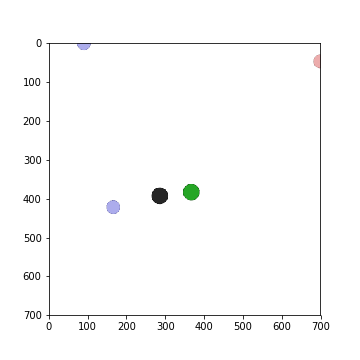
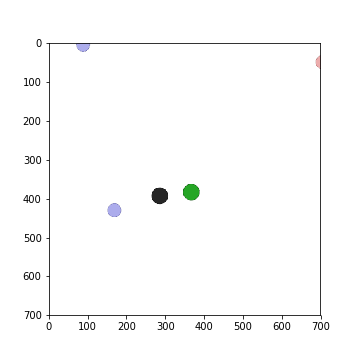
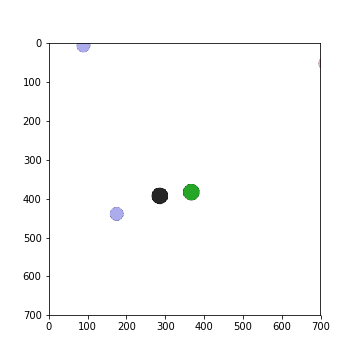
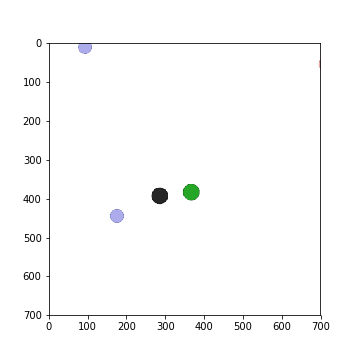
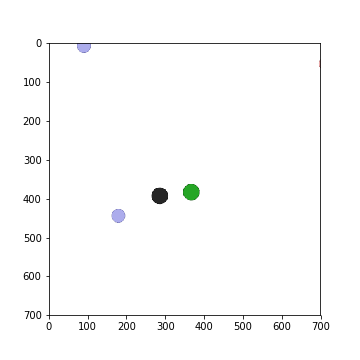
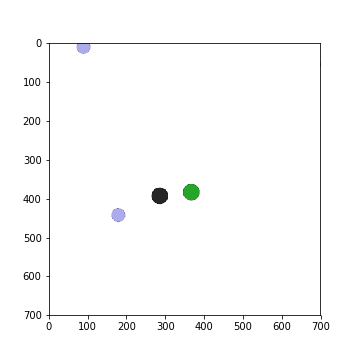
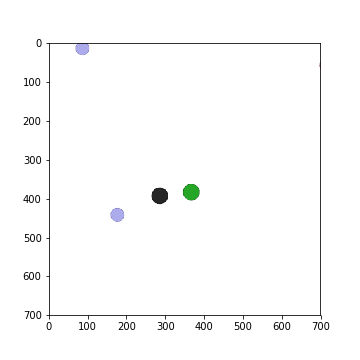
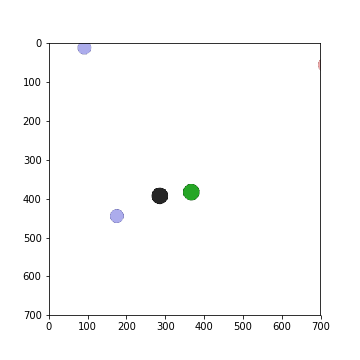
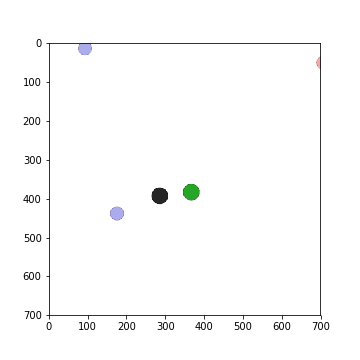
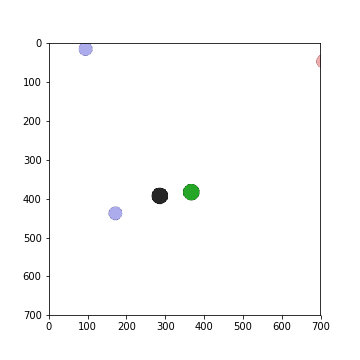
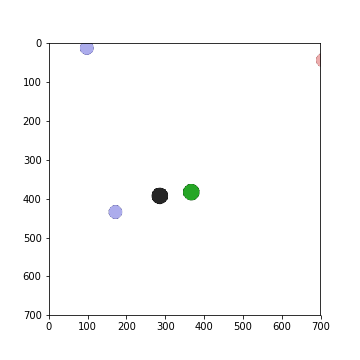
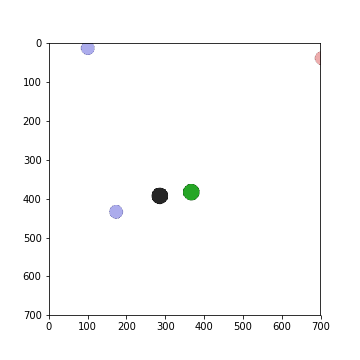
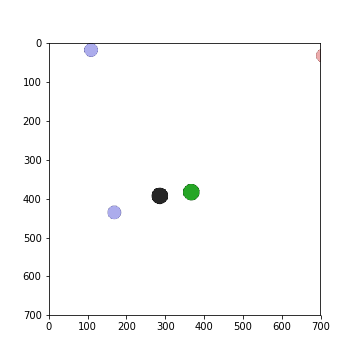
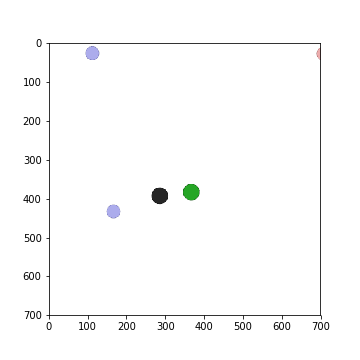
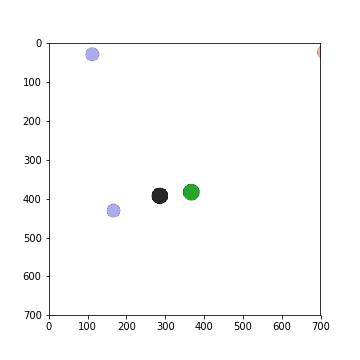
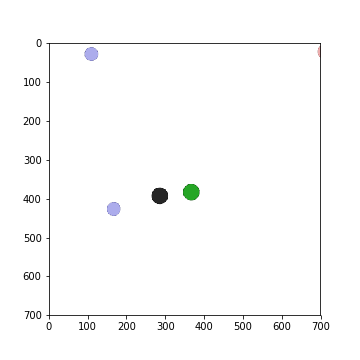
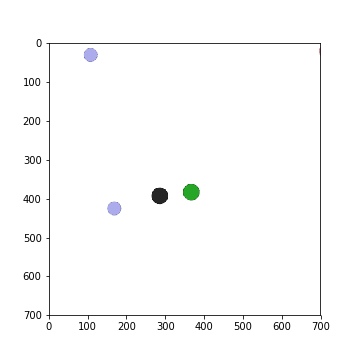
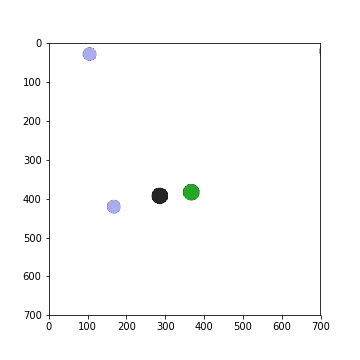
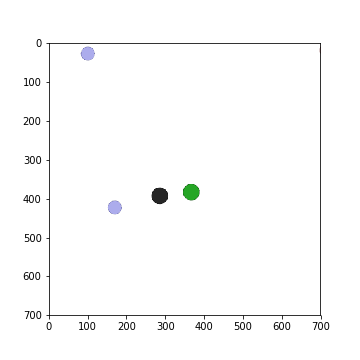
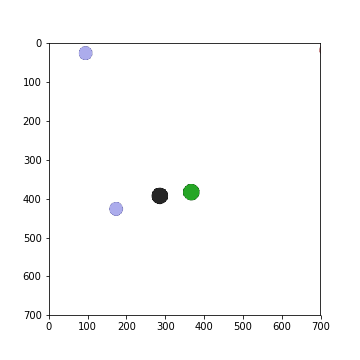
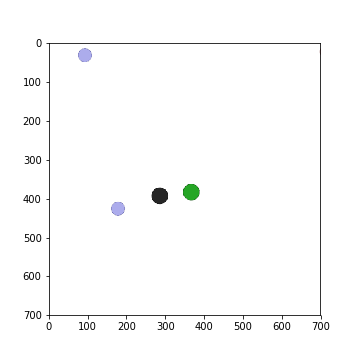
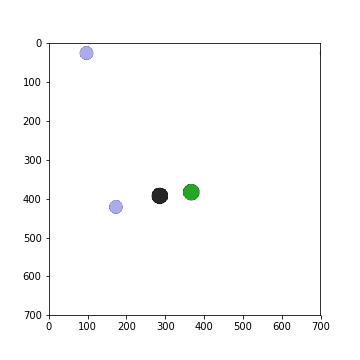
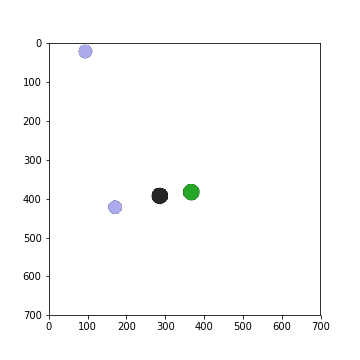
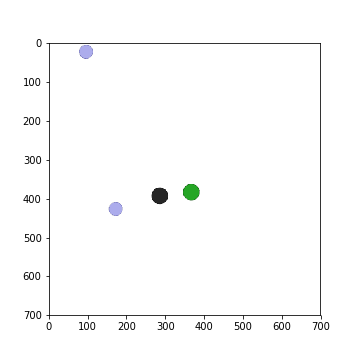
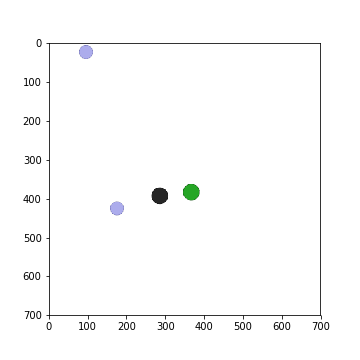
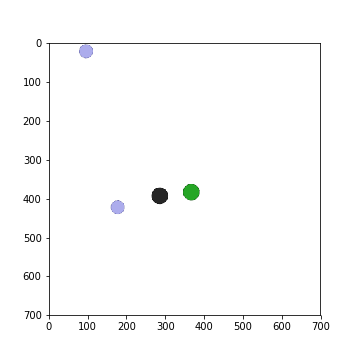
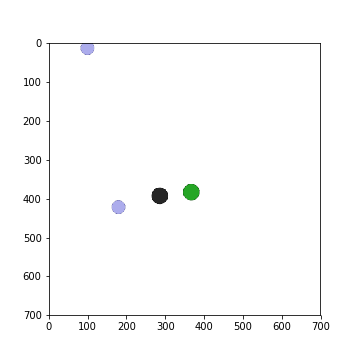
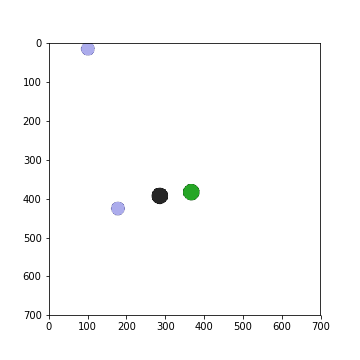
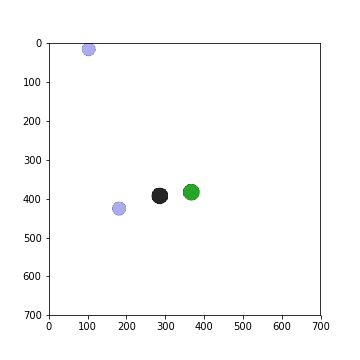
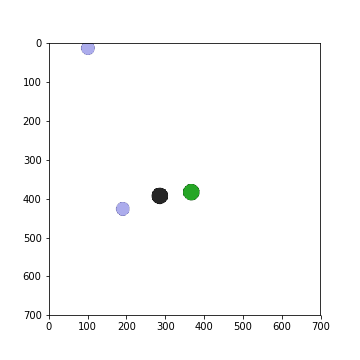
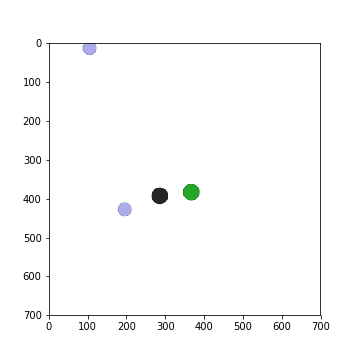
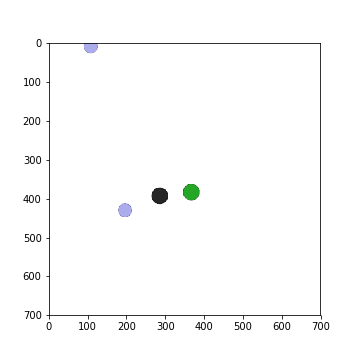
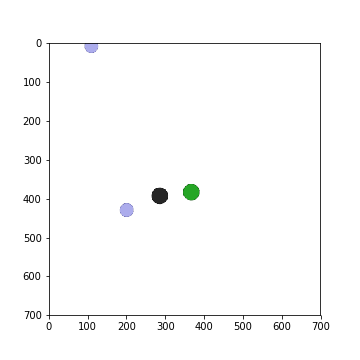
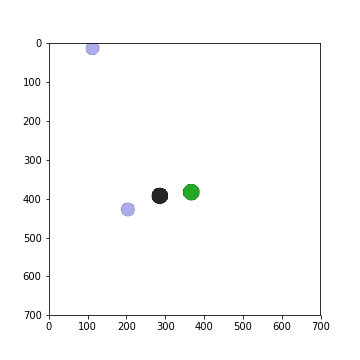
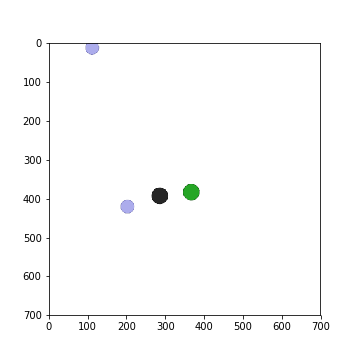
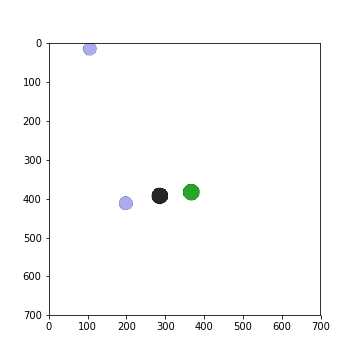
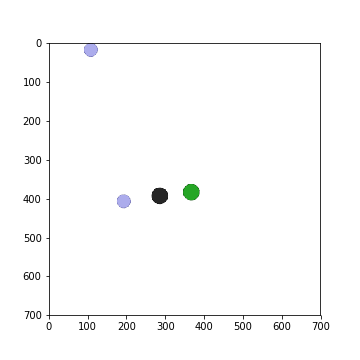
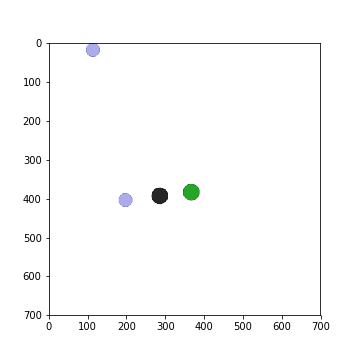
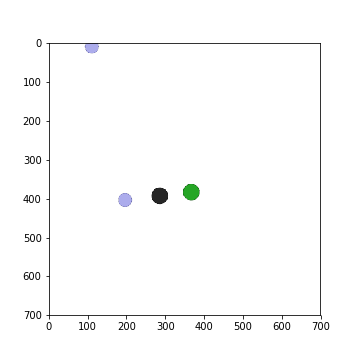
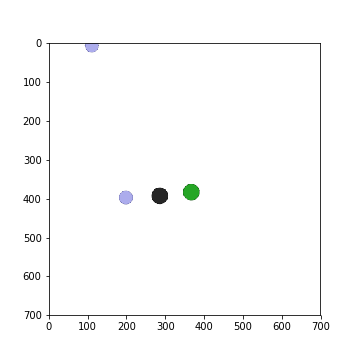
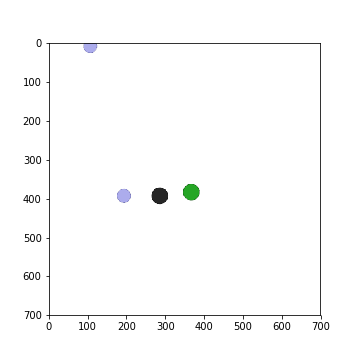
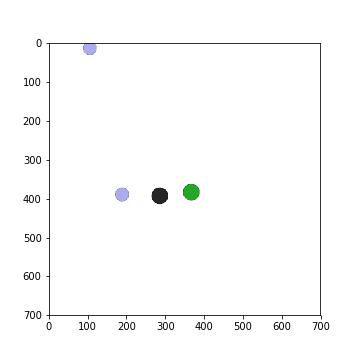
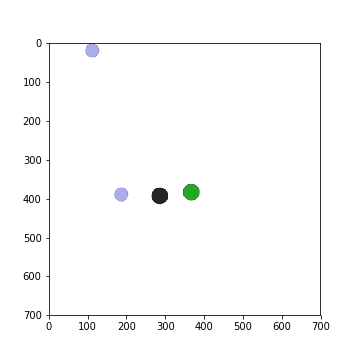
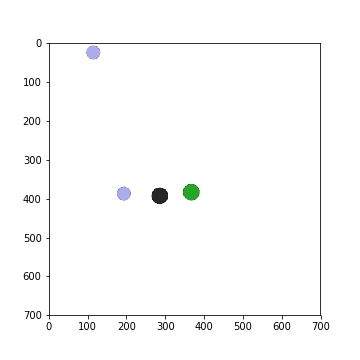
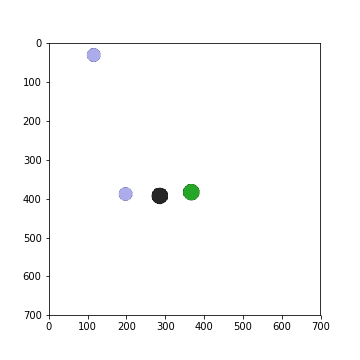
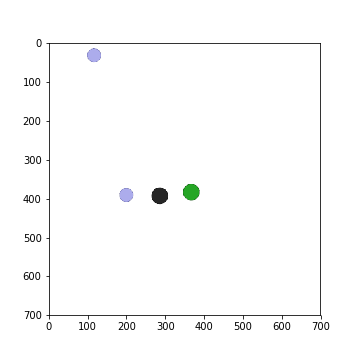
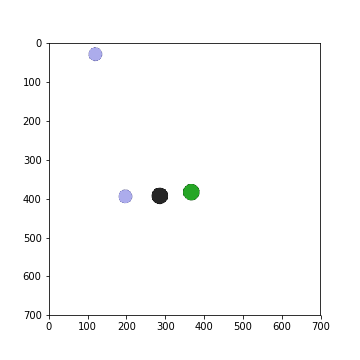
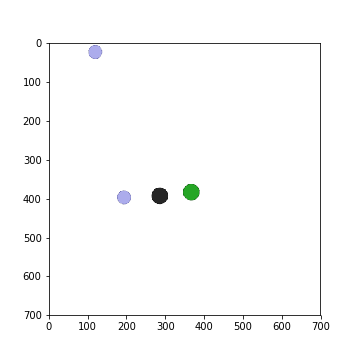
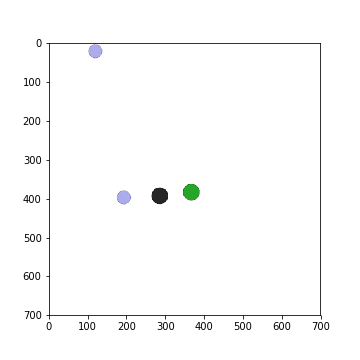
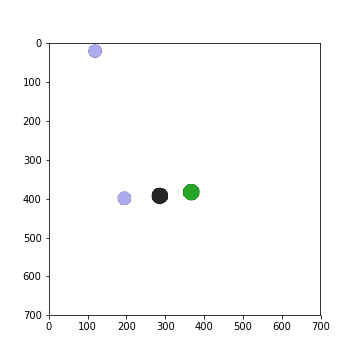
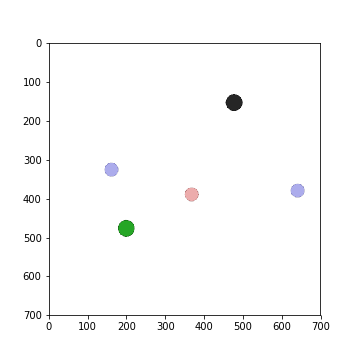
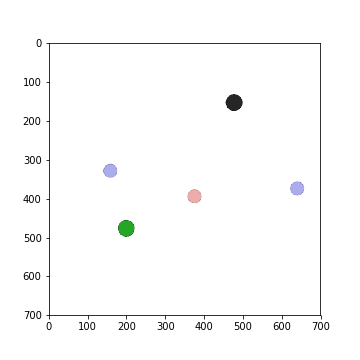
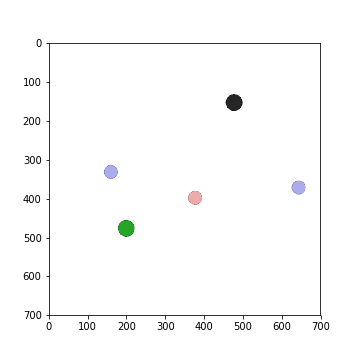
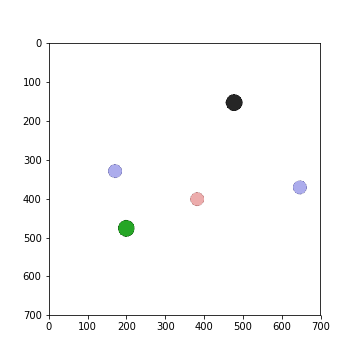
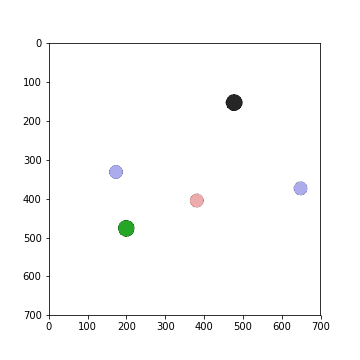
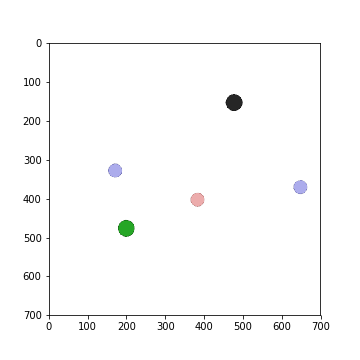
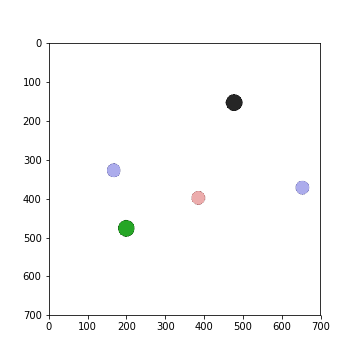
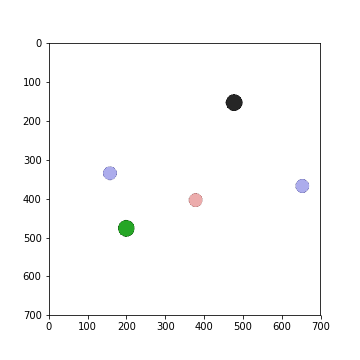
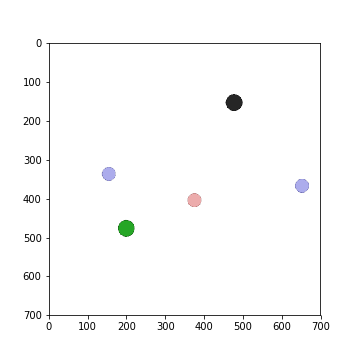
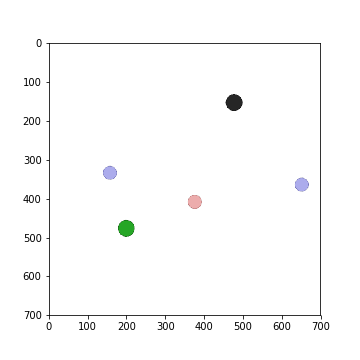
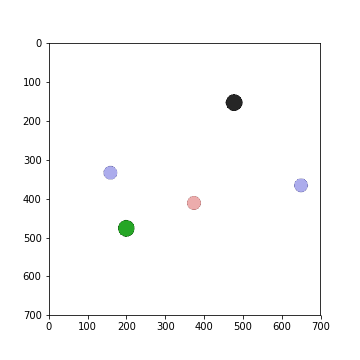
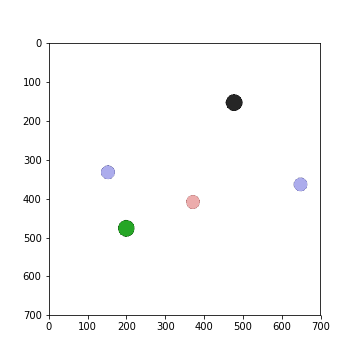
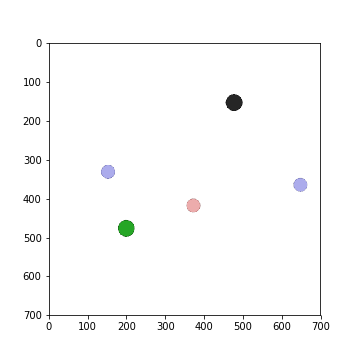
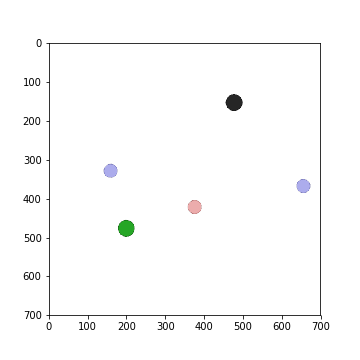
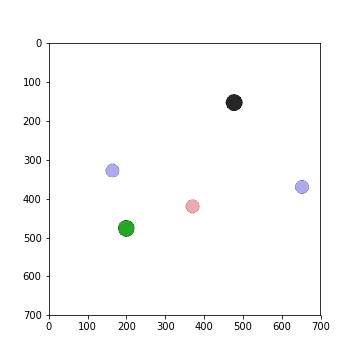
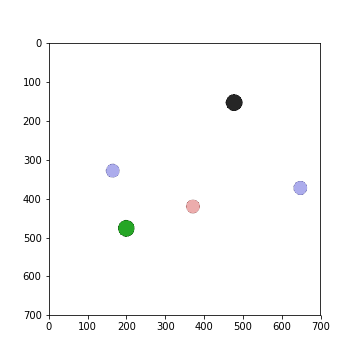
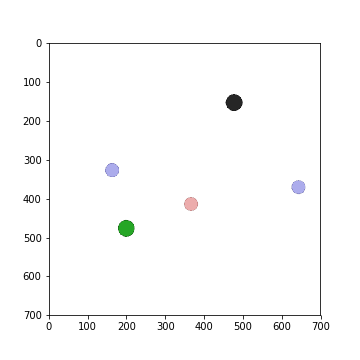
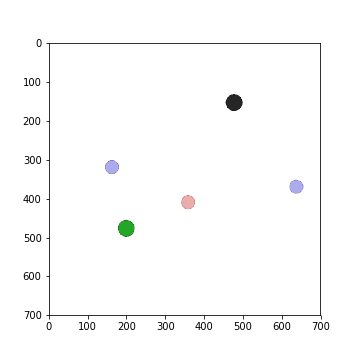
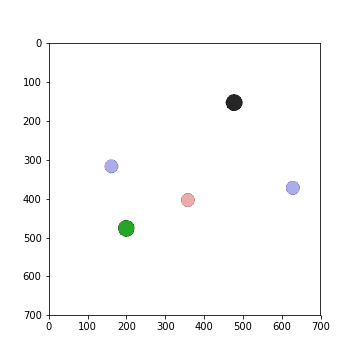
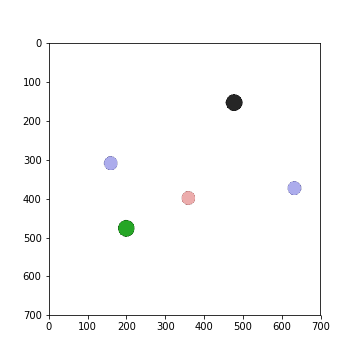
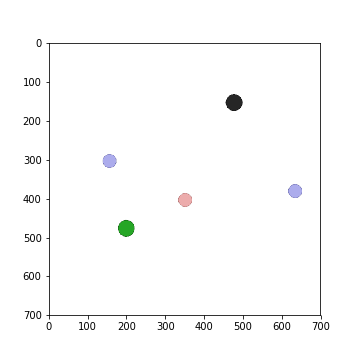
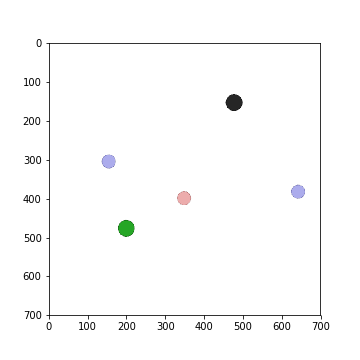
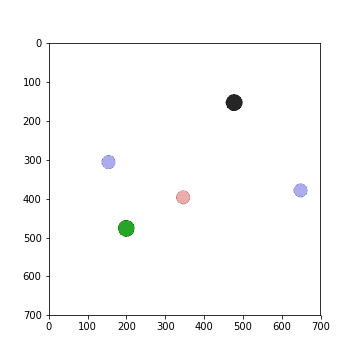
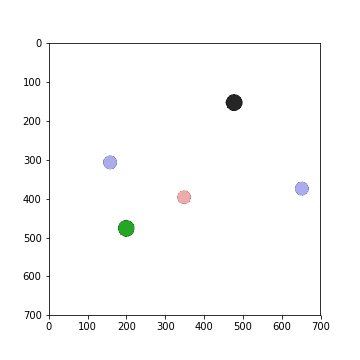
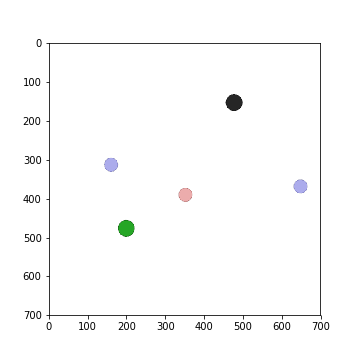
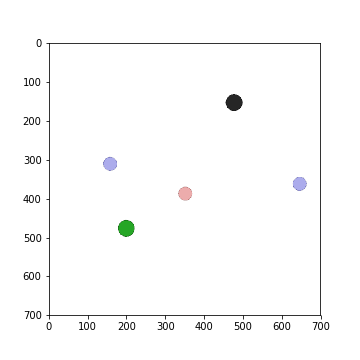
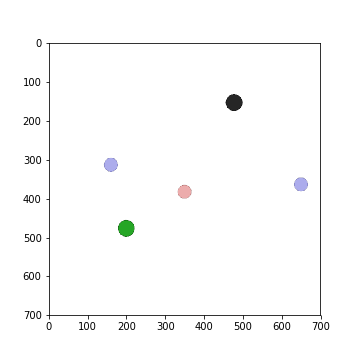
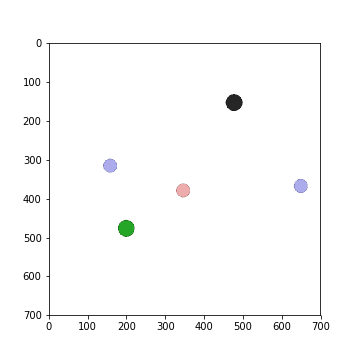
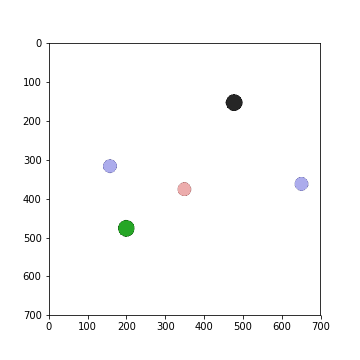
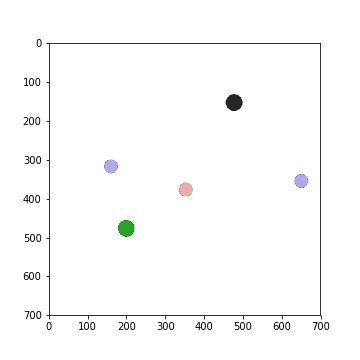
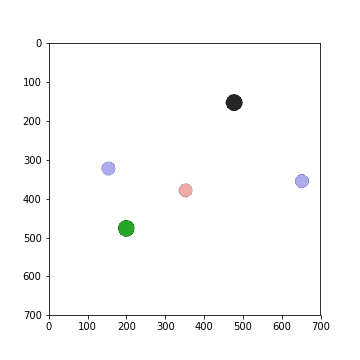
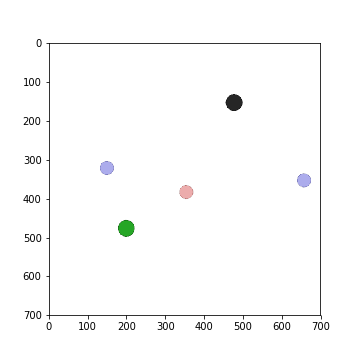
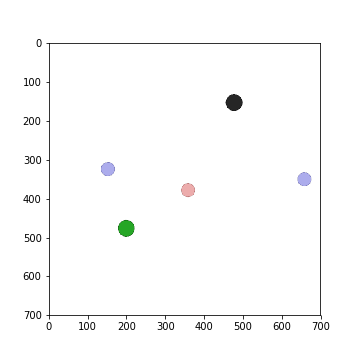
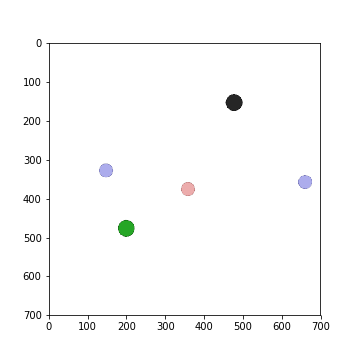
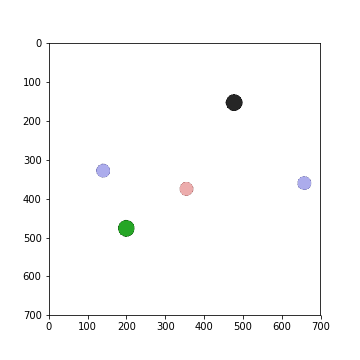
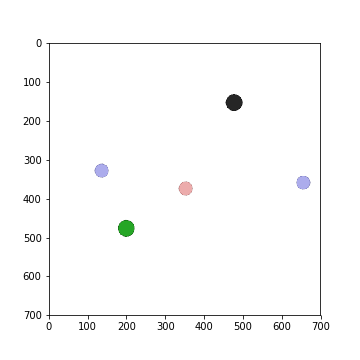
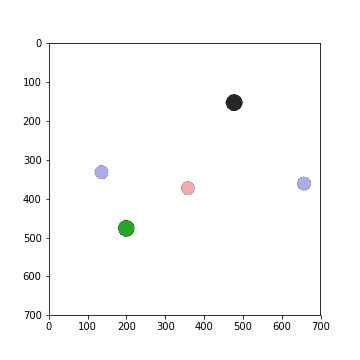
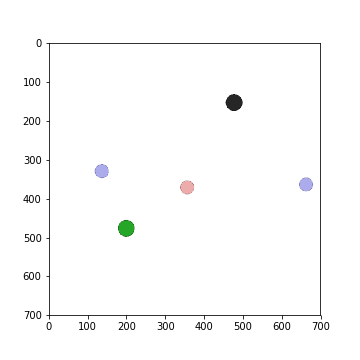
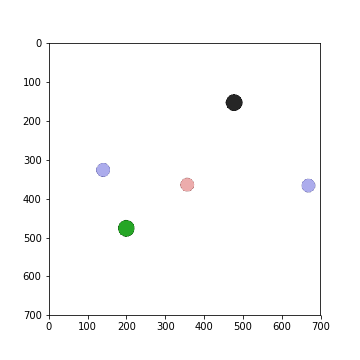
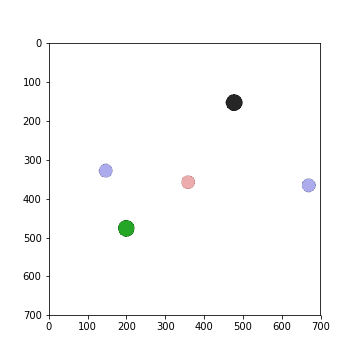
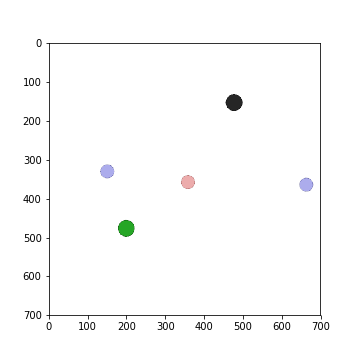
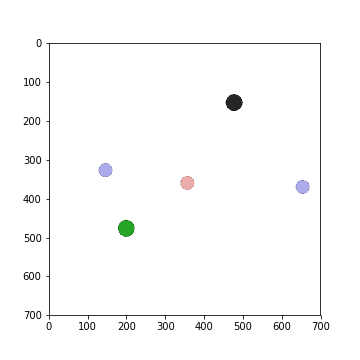
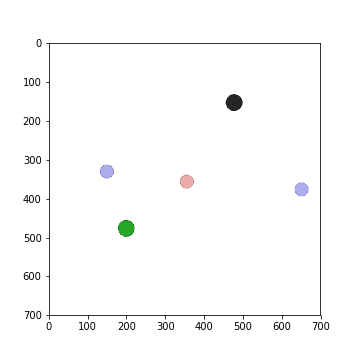
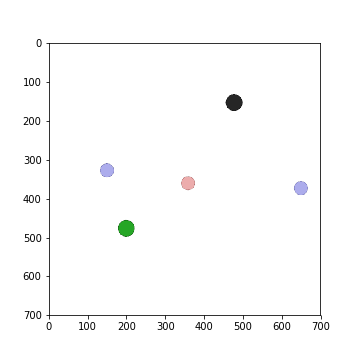
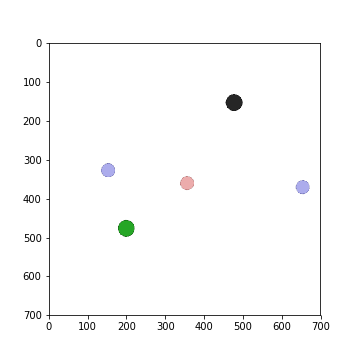
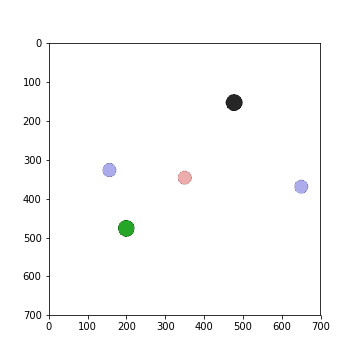
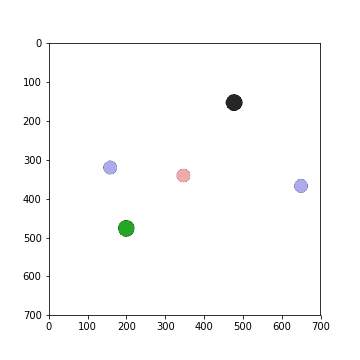
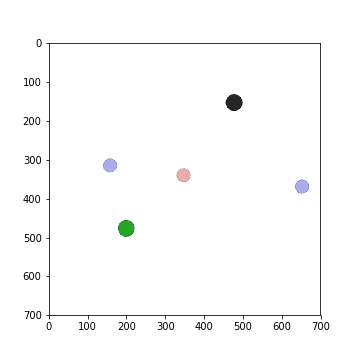
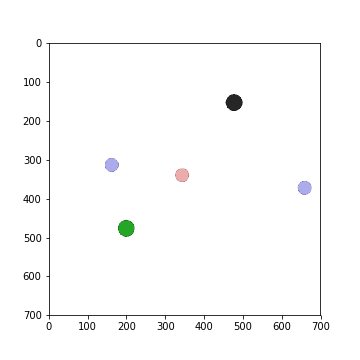
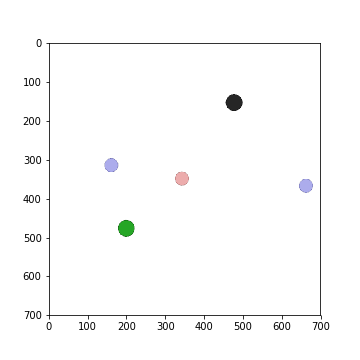
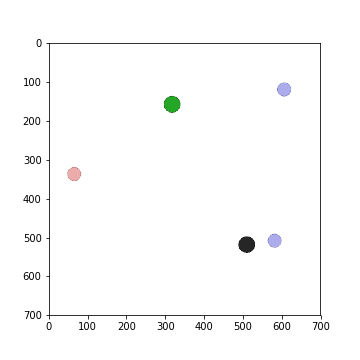
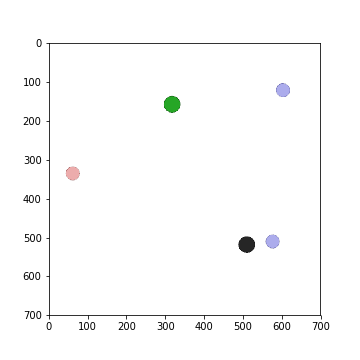
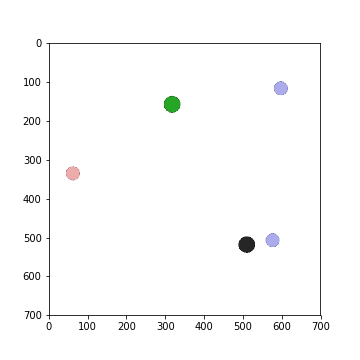
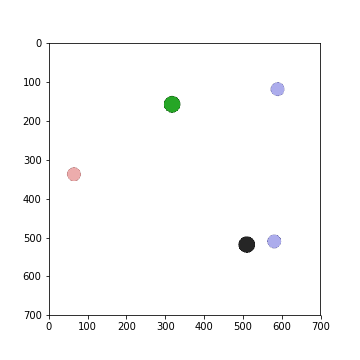
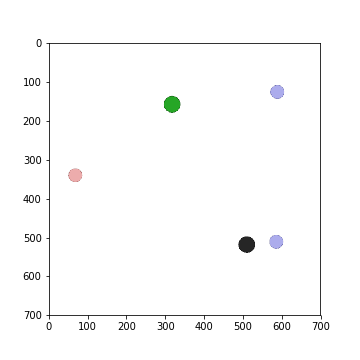
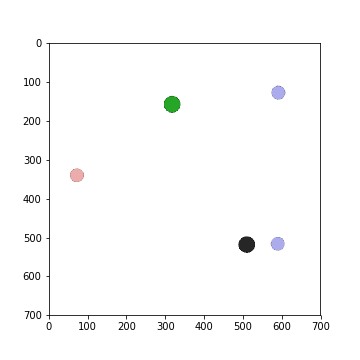
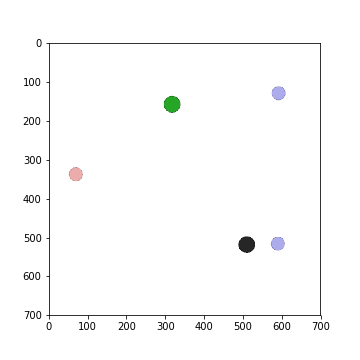
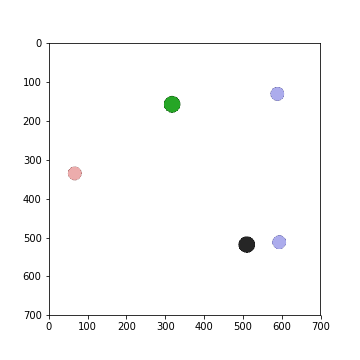
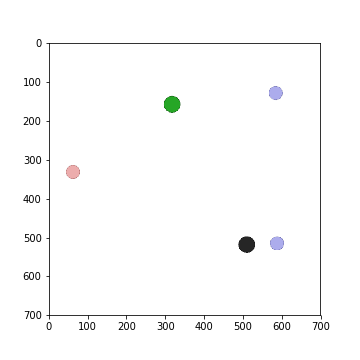
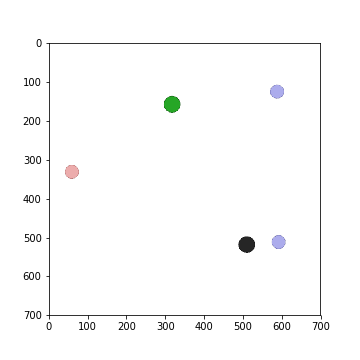
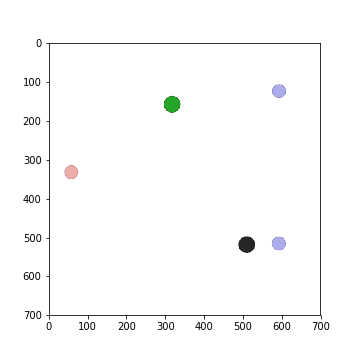
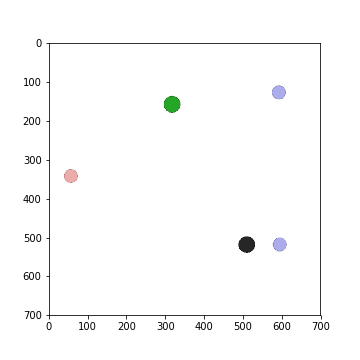
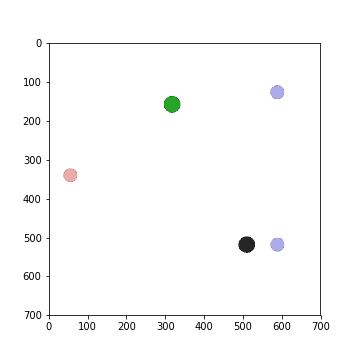
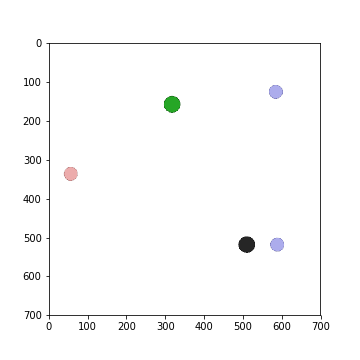
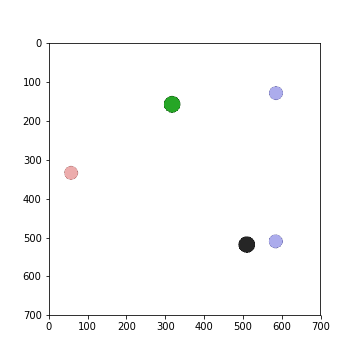
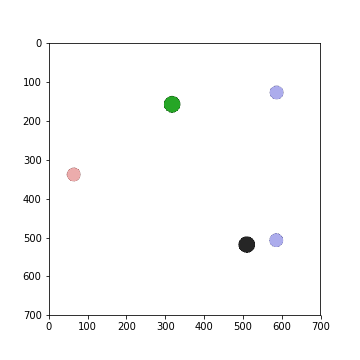
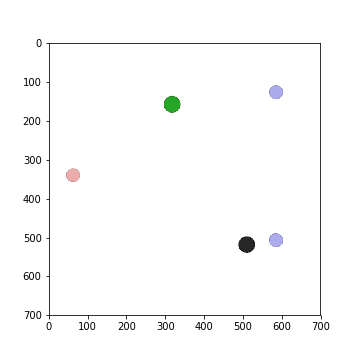
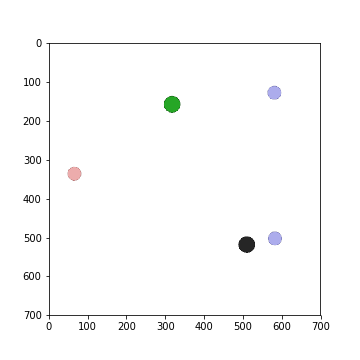
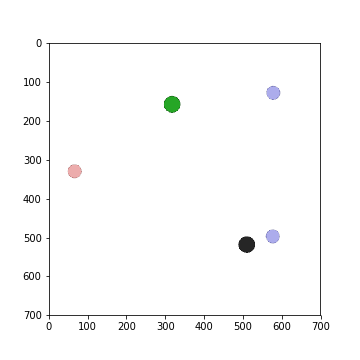
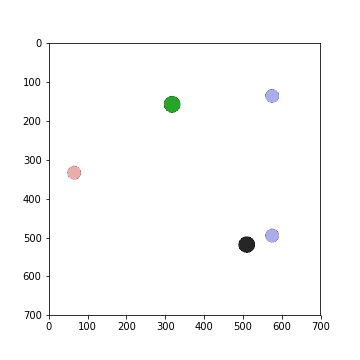
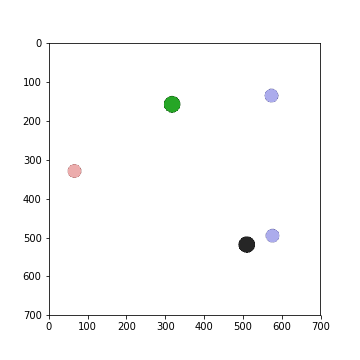
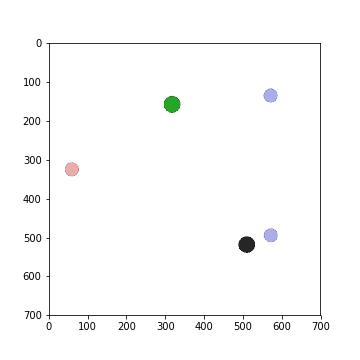
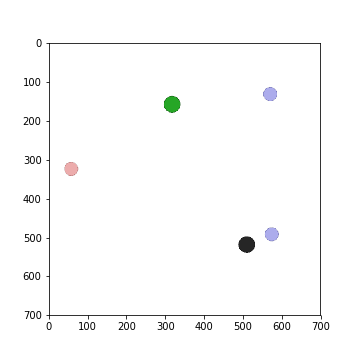
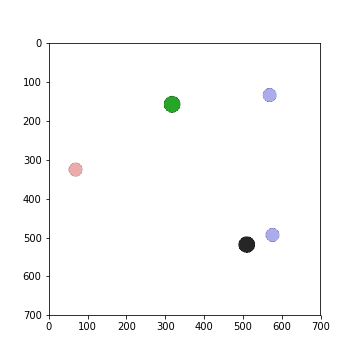
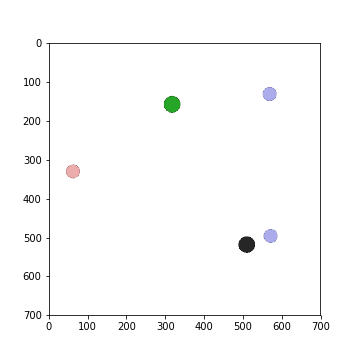
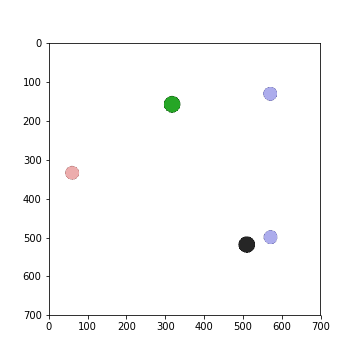
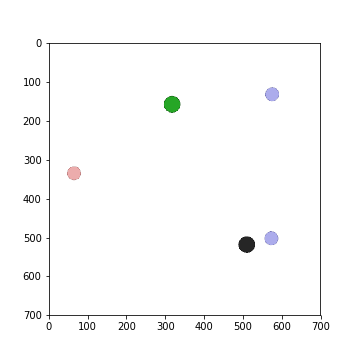
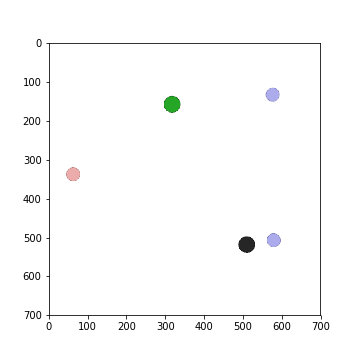
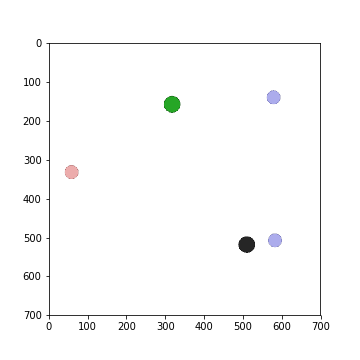
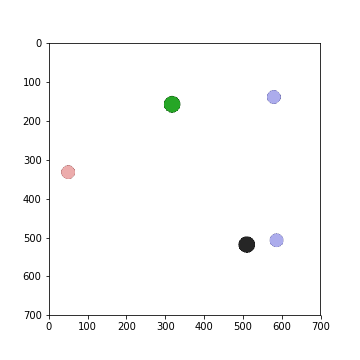
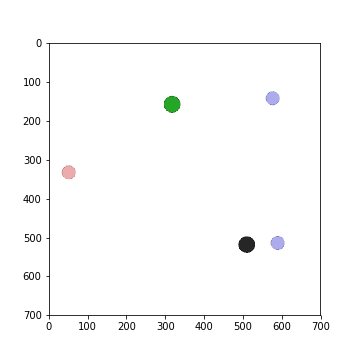
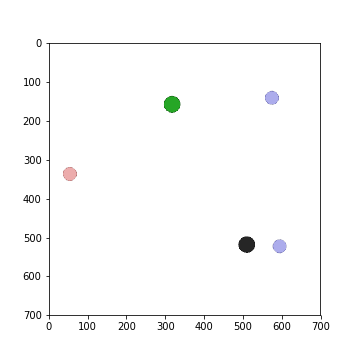
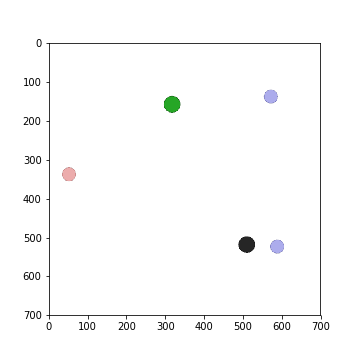
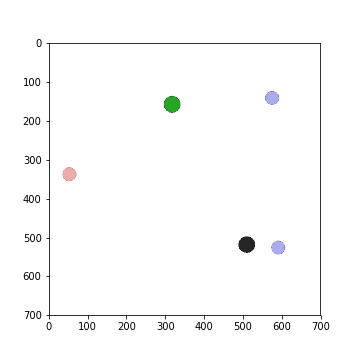
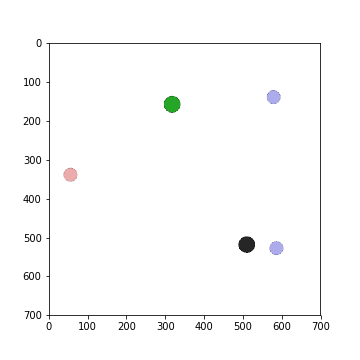
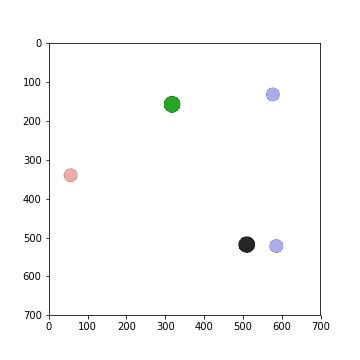
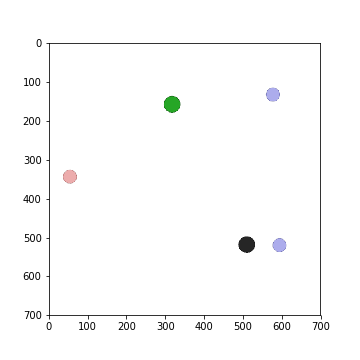
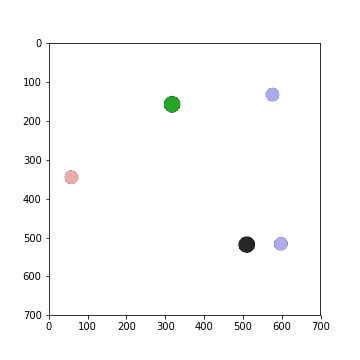
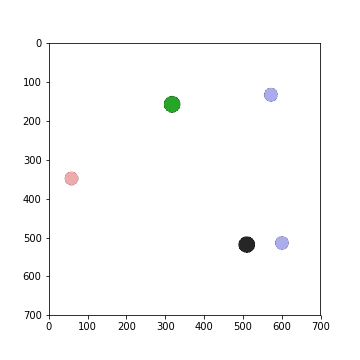
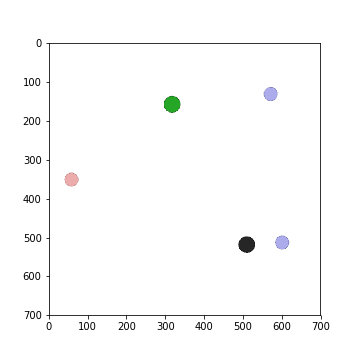
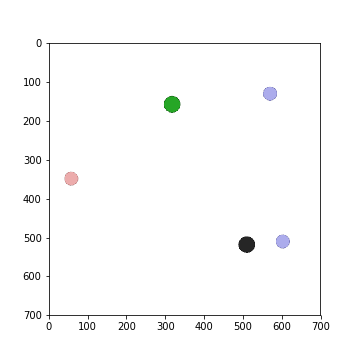
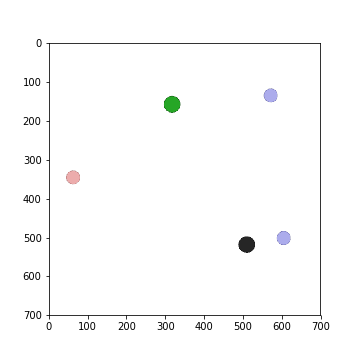
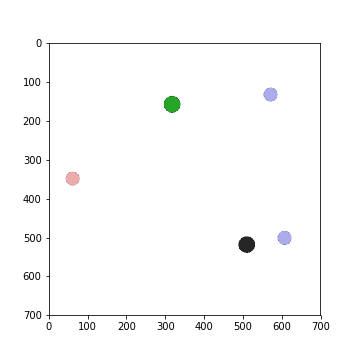
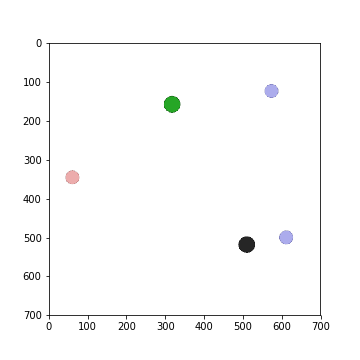
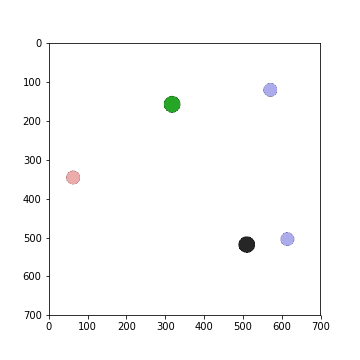
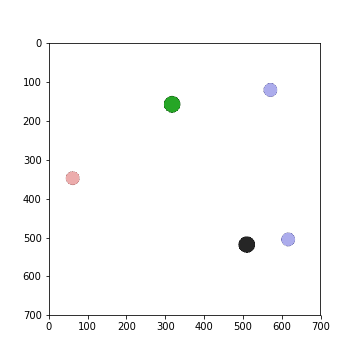
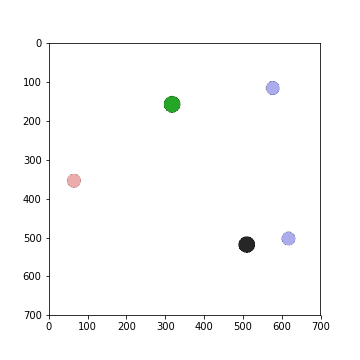
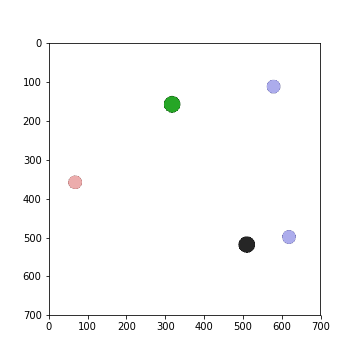
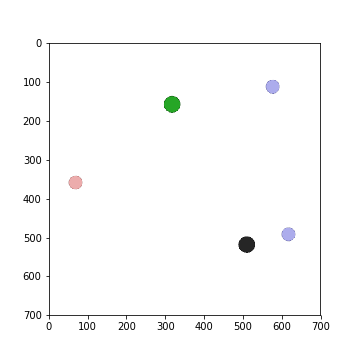
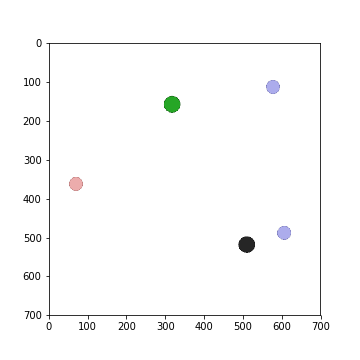
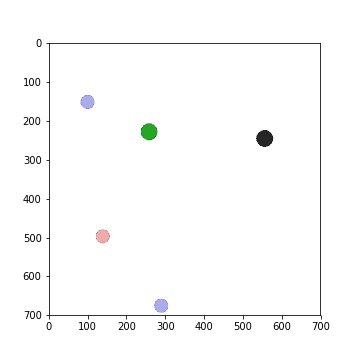
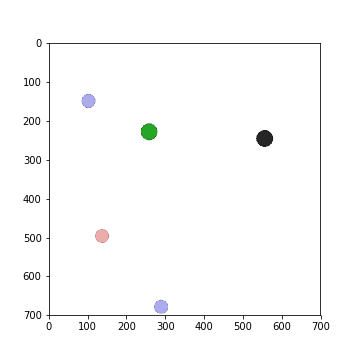
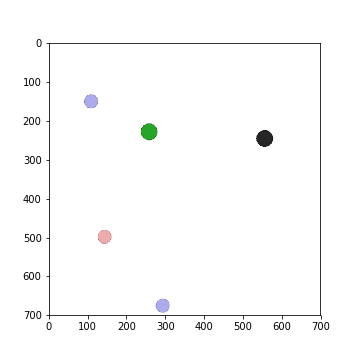
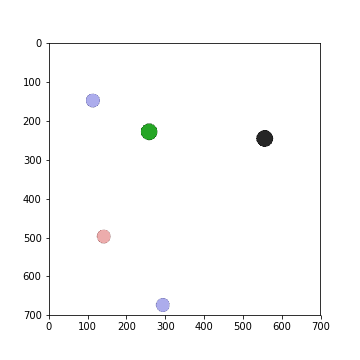
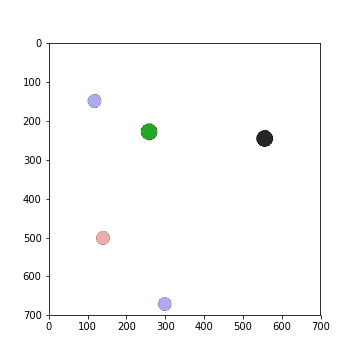
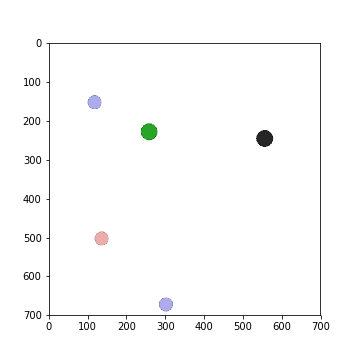
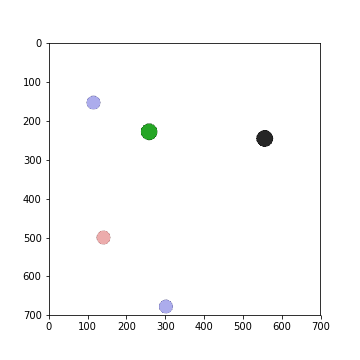
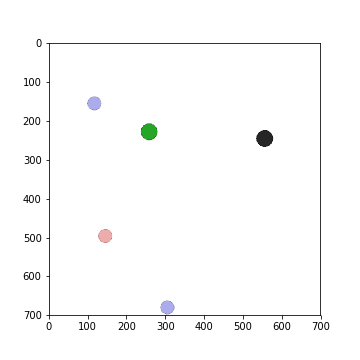
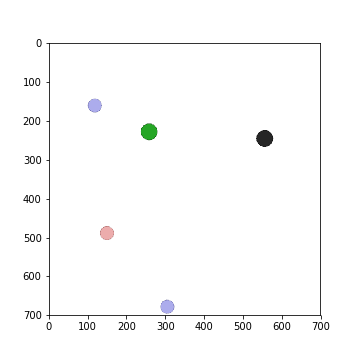
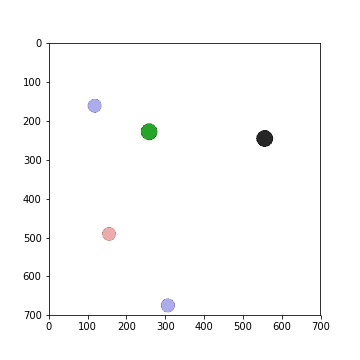
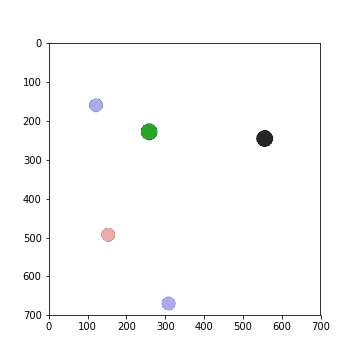
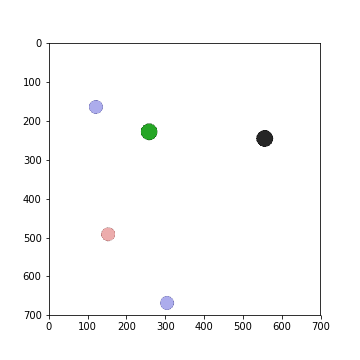
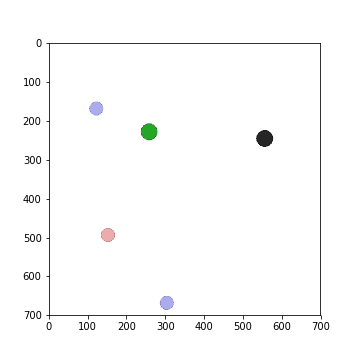
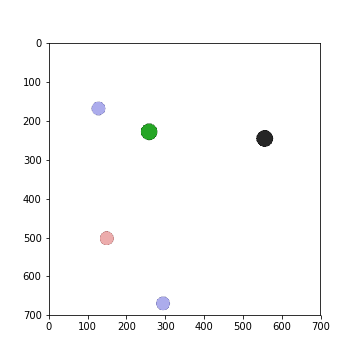
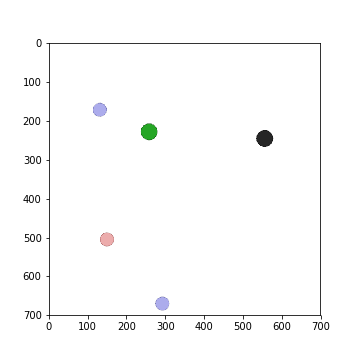
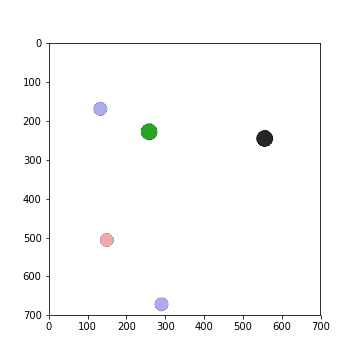
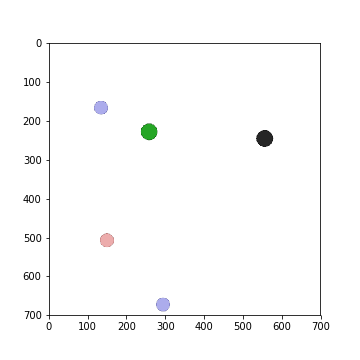
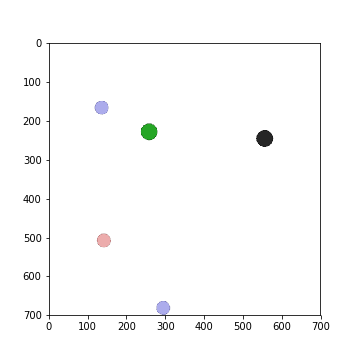
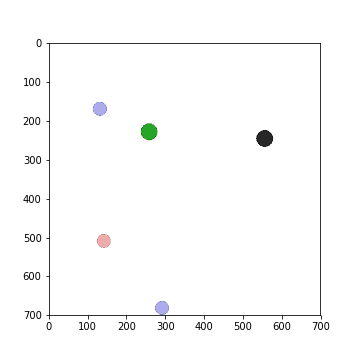
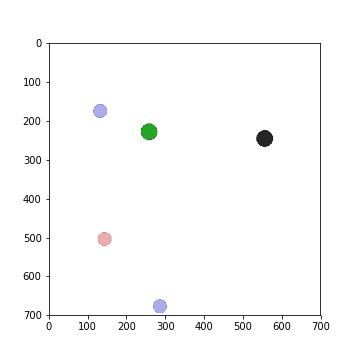
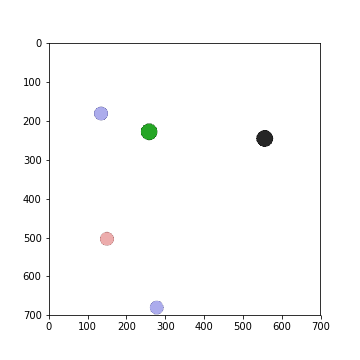
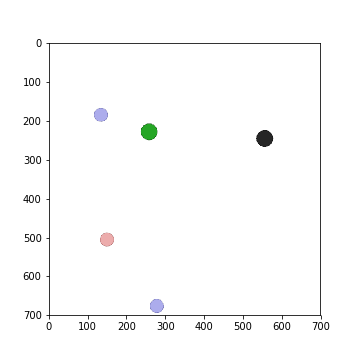
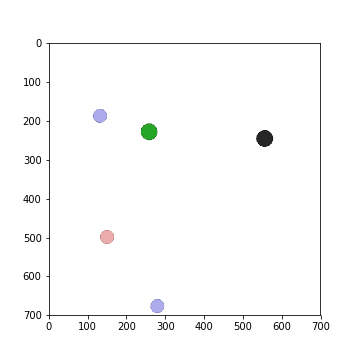
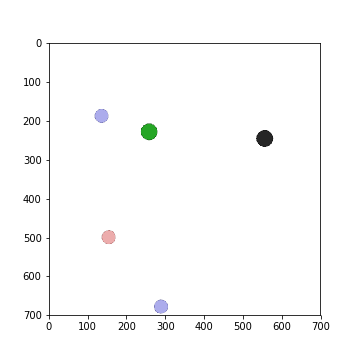
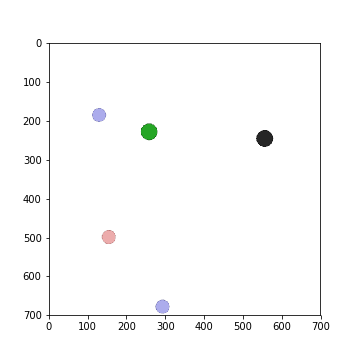
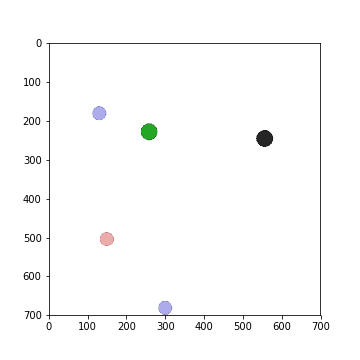
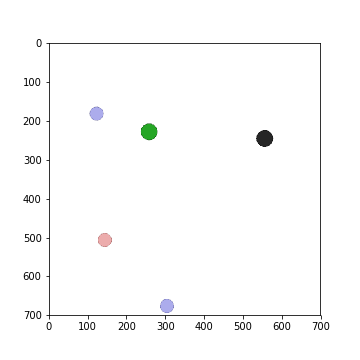
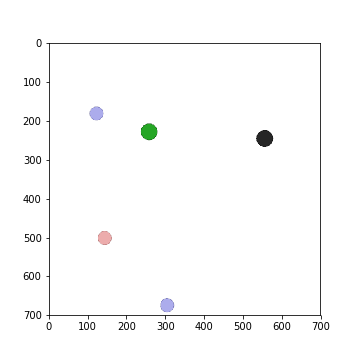
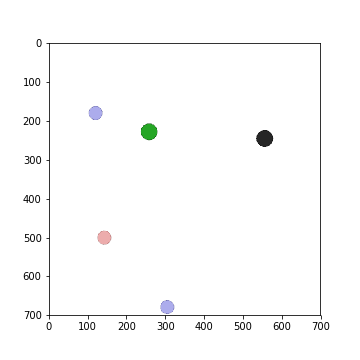
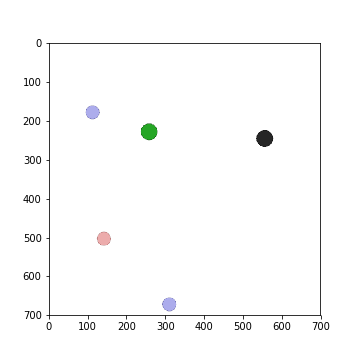
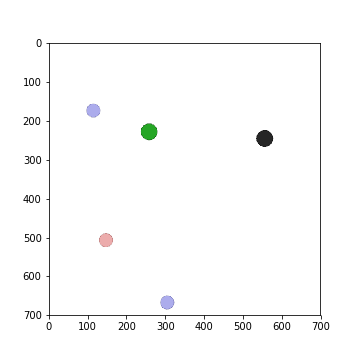
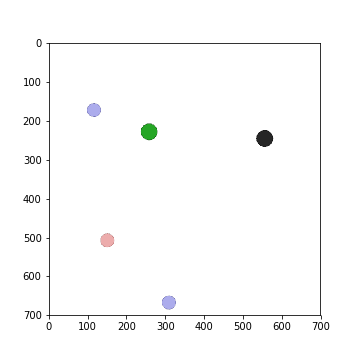
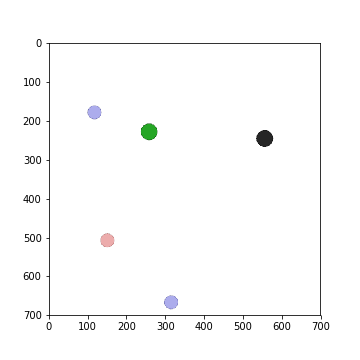
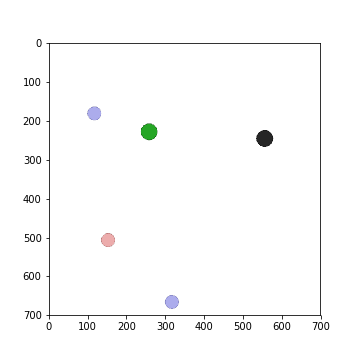
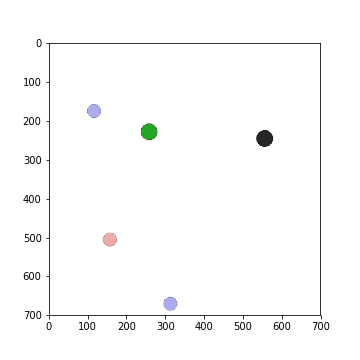
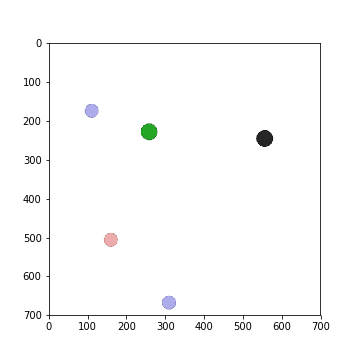
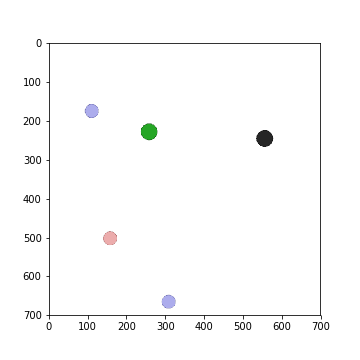
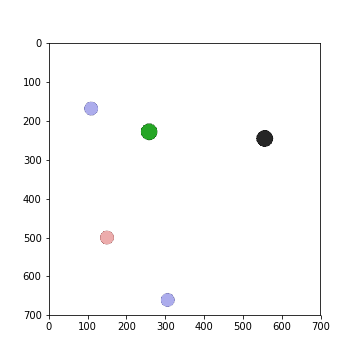
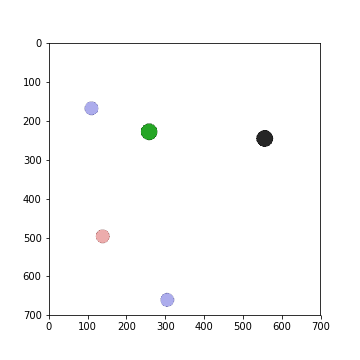
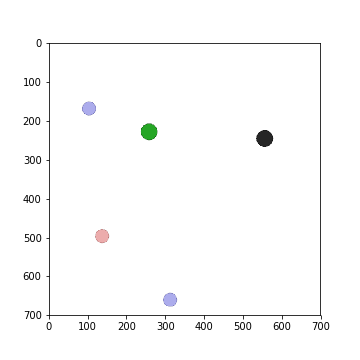
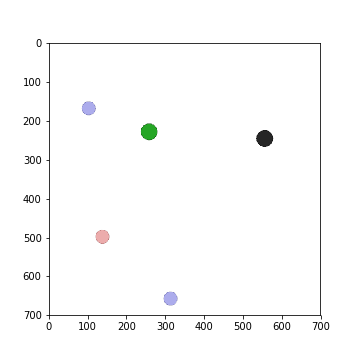
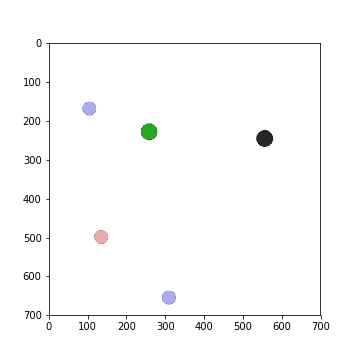
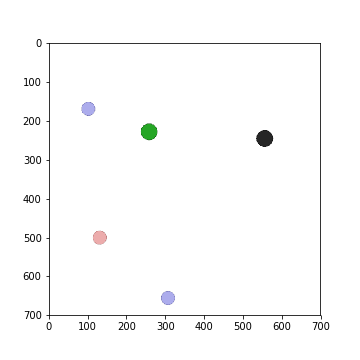
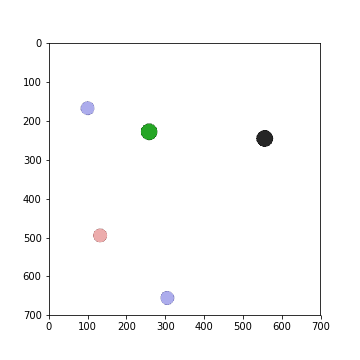
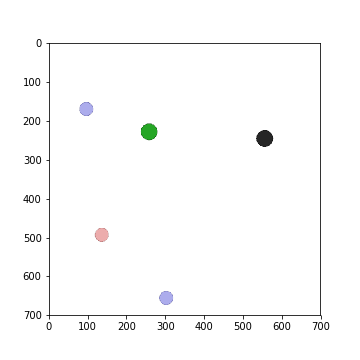
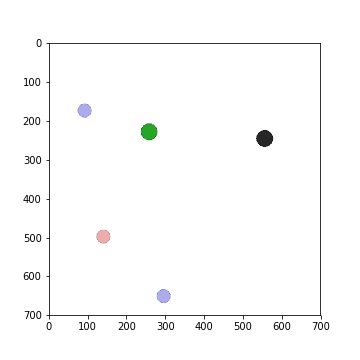
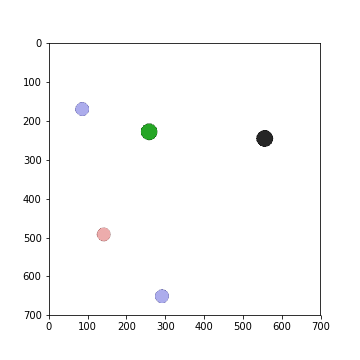
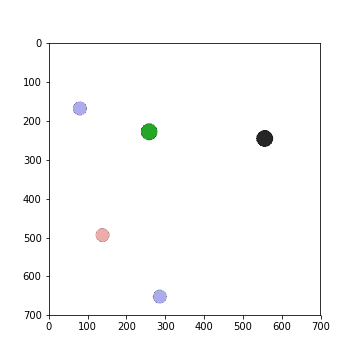
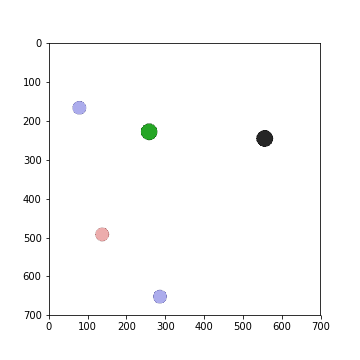
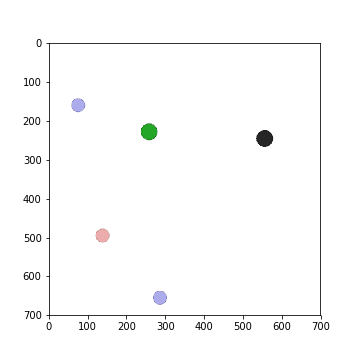
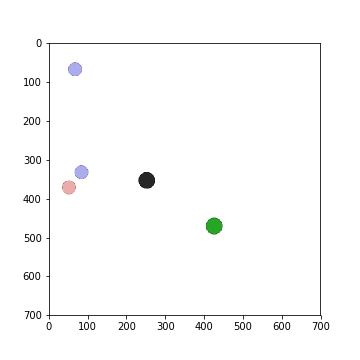
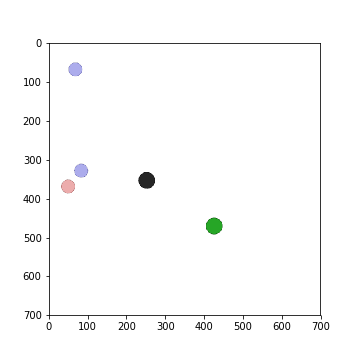
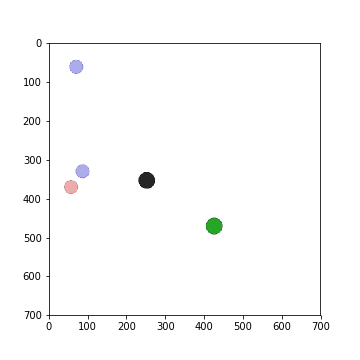
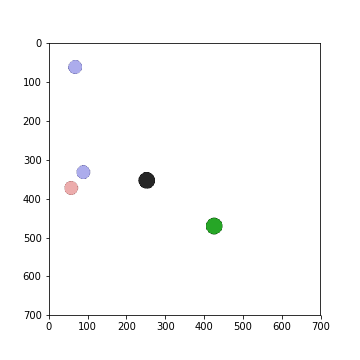
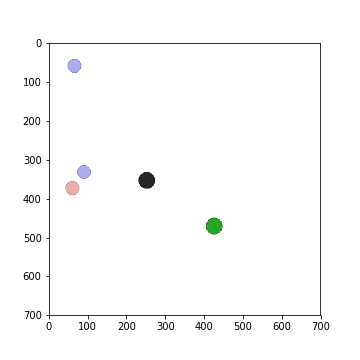
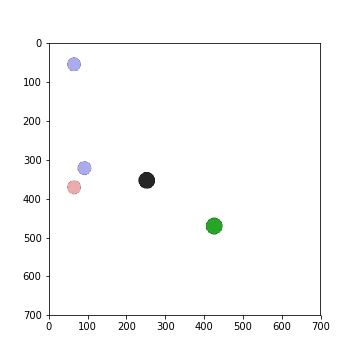
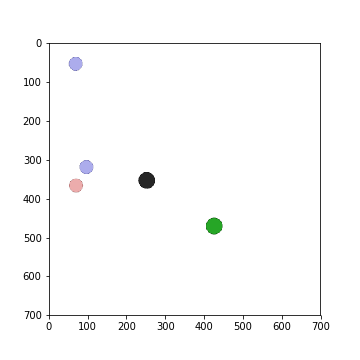
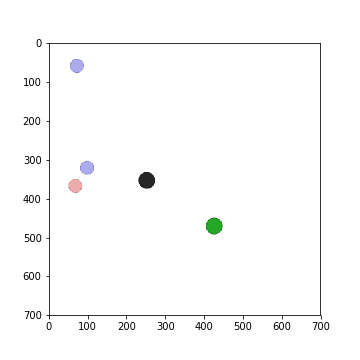
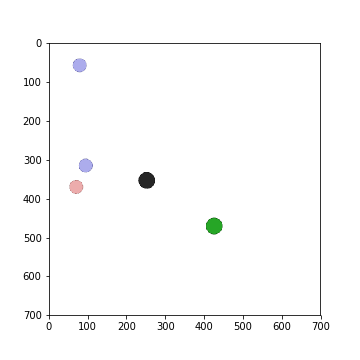
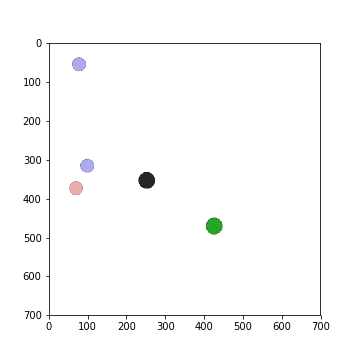
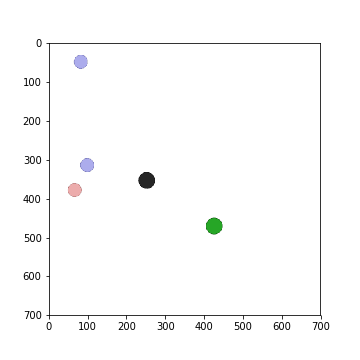
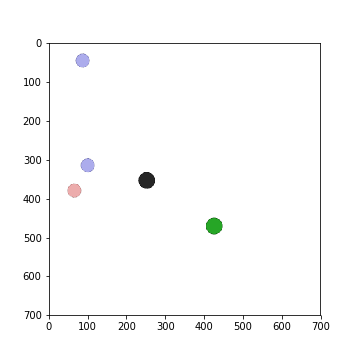
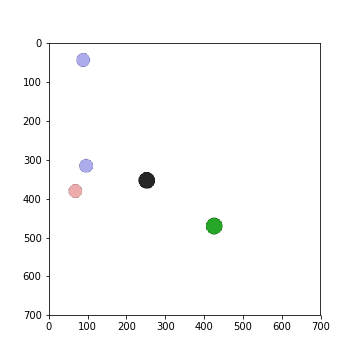
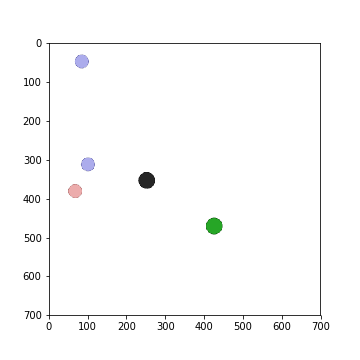
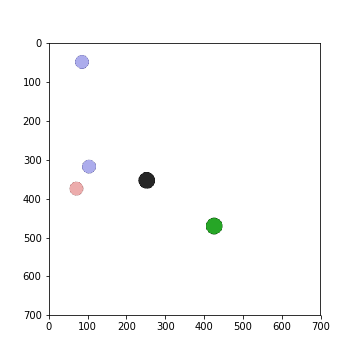
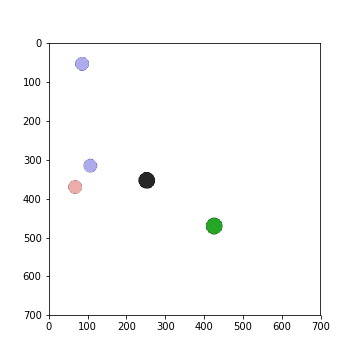
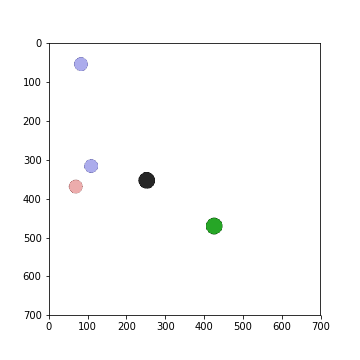
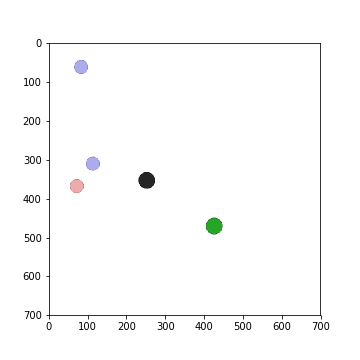
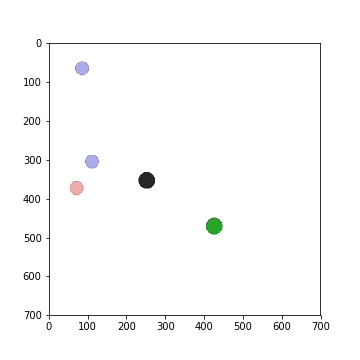
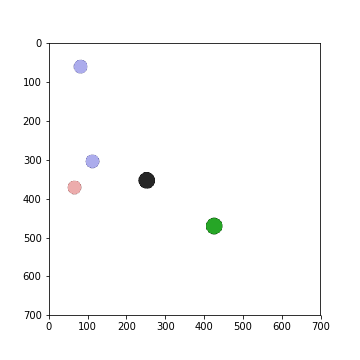
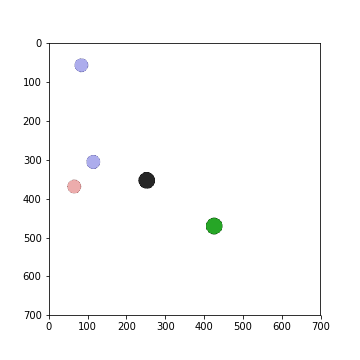
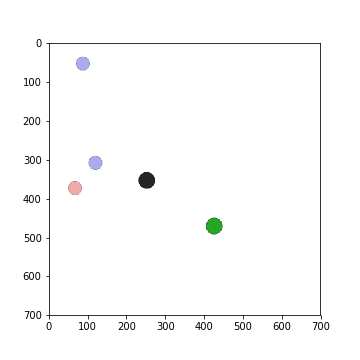
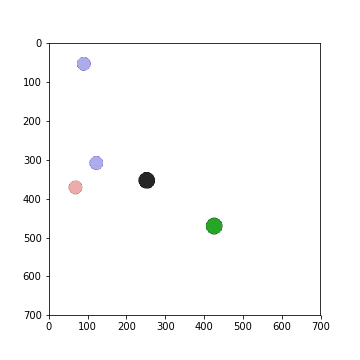
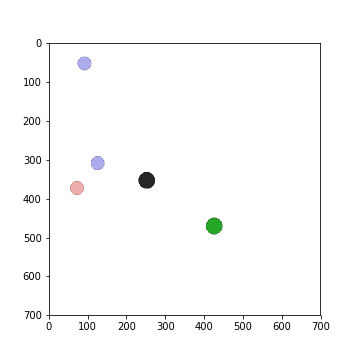
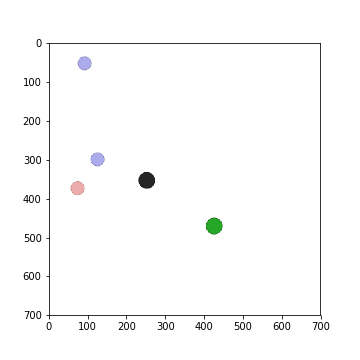
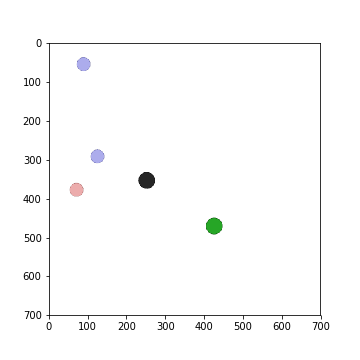
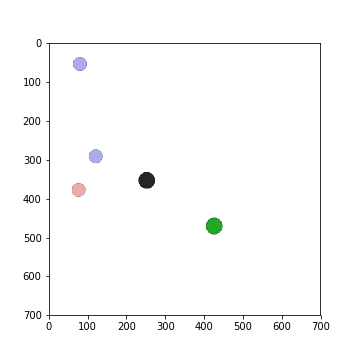
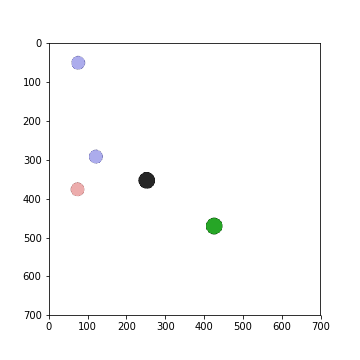
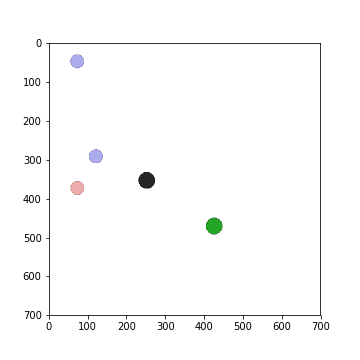
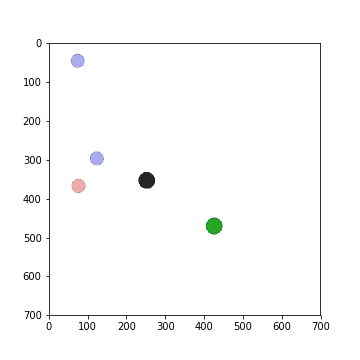
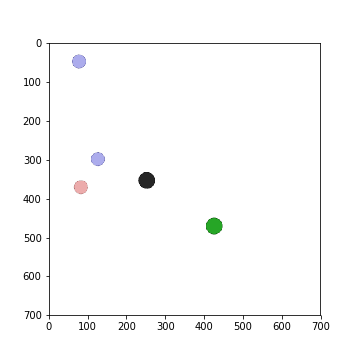
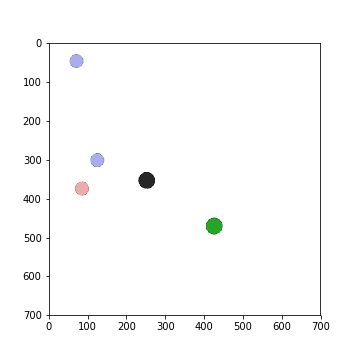
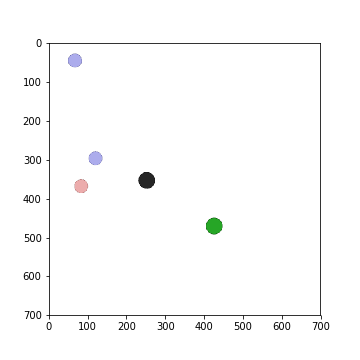
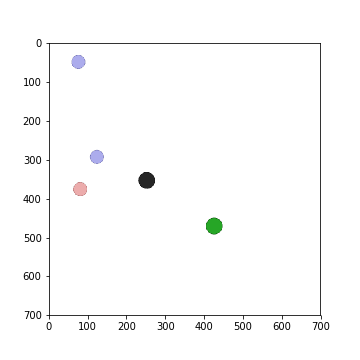
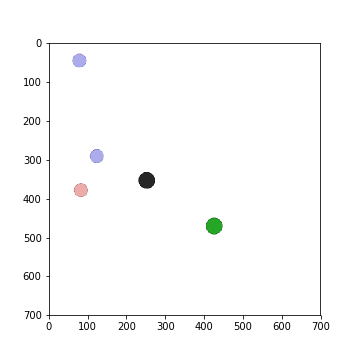
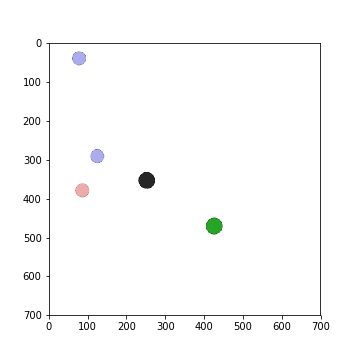
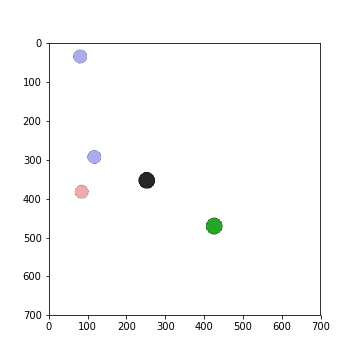
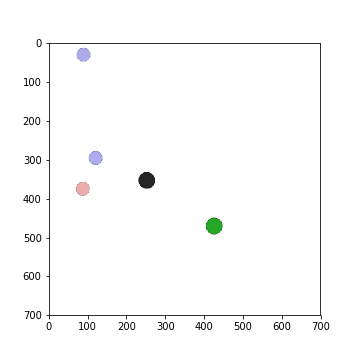
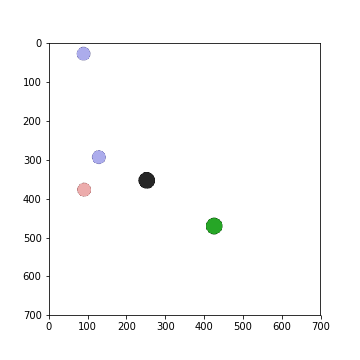
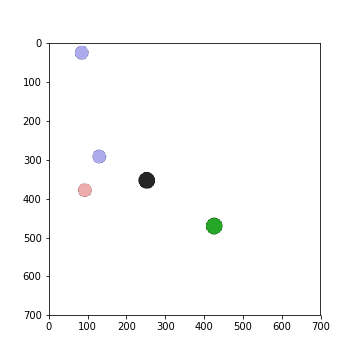
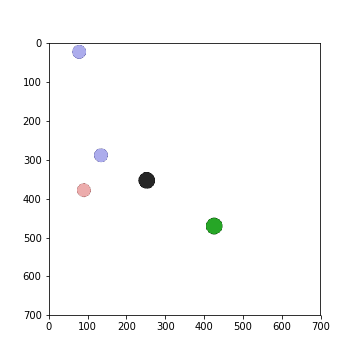
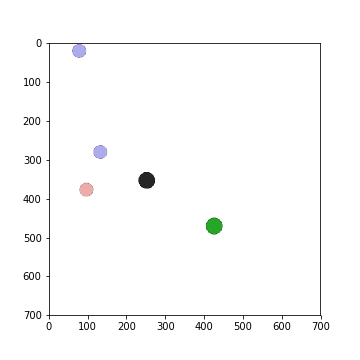
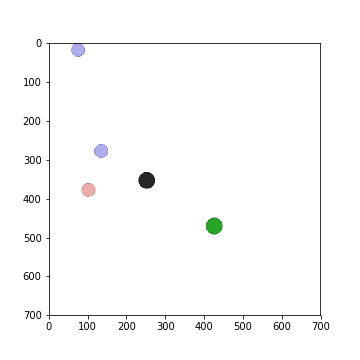
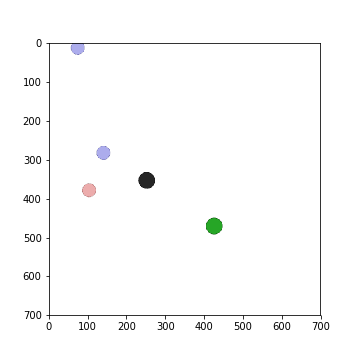
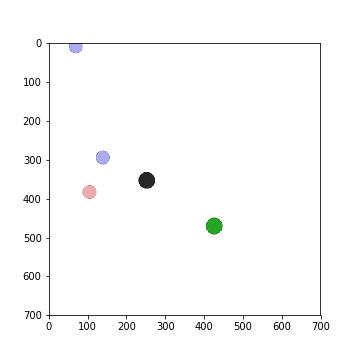
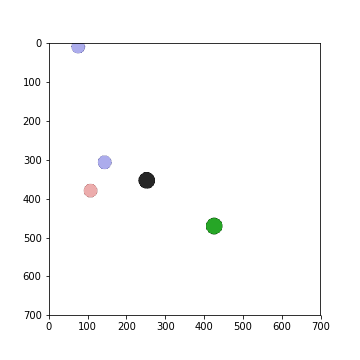
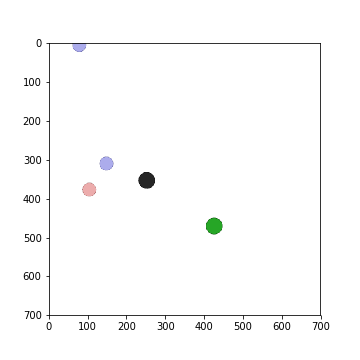
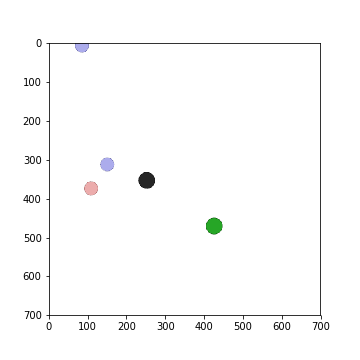
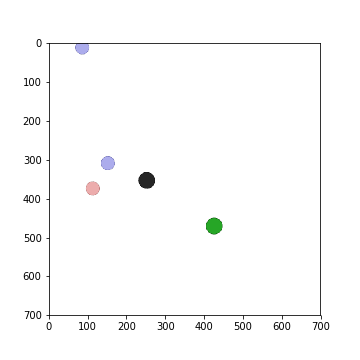
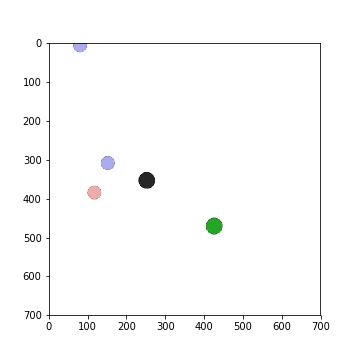

In [7]:
#Demo: by default random agents and 5 episode (quite boring but meh)
play_demo('demo.gif', "simple_adversary")

### Train

Using 4 agents in paralell

In [9]:
env_name = "simple_adversary"

#number of threads
parallel_envs = 4

# number of training episodes.
number_of_episodes = 10000
episode_length = 80
batchsize = 1000
t = 0

# amplitude of OU noise
# this slowly decreases to 0
noise = 2
noise_reduction = 0.9999

# how many episodes before update
episode_per_update = 2 * parallel_envs

#Make env
torch.set_num_threads(parallel_envs)
env = envs.make_parallel_env(env_name, parallel_envs)

# keep 5000 episodes worth of replay
buffer = ReplayBuffer(int(5000*episode_length))

#save weights to disk
save_weights = True

# initialize policy and critic
maddpg = MADDPG()

#Rewards
agent0_reward = []
agent1_reward = []
agent2_reward = []

agent0_reward_list = []
agent1_reward_list = []
agent2_reward_list = []

#### Train Loop

In [10]:
PRINT_EVERY = 100

for episode in range(0, number_of_episodes, parallel_envs):

        reward_this_episode = np.zeros((parallel_envs, 3))
        all_obs = env.reset()
        obs, obs_full = transpose_list(all_obs)
               
        for episode_t in range(episode_length):
           
            # actions = critics(obs)
            actions = maddpg.act(transpose_to_tensor(obs), noise=noise)                     
            actions_array = torch.stack(actions).detach().numpy()
            actions_for_env = np.rollaxis(actions_array,1)
            
            # step forward one frame
            next_obs, next_obs_full, rewards, dones, info = env.step(actions_for_env)
            
            # push transition to buffer
            transition = (obs, obs_full, actions_for_env, rewards, next_obs, next_obs_full, dones)
            buffer.push(transition)
            
            # update episode rewards
            reward_this_episode += rewards
            
            # update observations and noise
            obs, obs_full = next_obs, next_obs_full
            noise *= noise_reduction
        
        # update once after every episode_per_update
        if len(buffer) > batchsize and episode % episode_per_update < parallel_envs:
            for a_i in range(3):
                samples = buffer.sample(batchsize)
                maddpg.update(samples, a_i)
            #soft-update the target networks
            maddpg.update_targets() 
       
        # append rewards
        for i in range(parallel_envs):
            agent0_reward.append(reward_this_episode[i,0])
            agent1_reward.append(reward_this_episode[i,1])
            agent2_reward.append(reward_this_episode[i,2])
        
        avg_rewards = [np.mean(agent0_reward), np.mean(agent1_reward), np.mean(agent2_reward)]
        agent0_reward_list.append(avg_rewards[0])
        agent1_reward_list.append(avg_rewards[1])
        agent2_reward_list.append(avg_rewards[2])
        
        if episode % PRINT_EVERY == 0 or episode == number_of_episodes-1:
            # print training status
            print('\rEpisode:{}\tAgent_0 avg reward:{:.2f}\tAgent_1,2 avg reward:{:.2f}'.format(episode, avg_rewards[0], avg_rewards[1]))
            # temp list -->0
            agent0_reward = []
            agent1_reward = []
            agent2_reward = []    
            
#saving model: from one agent only
if save_weights:
    torch.save(maddpg.maddpg_agent[0].actor.state_dict(), 'actor_params.pth')
    torch.save(maddpg.maddpg_agent[0].actor_optimizer.state_dict(), 'actor_optim_params.pth')
    torch.save(maddpg.maddpg_agent[0].critic.state_dict(), 'critic_params.pth')
    torch.save(maddpg.maddpg_agent[0].critic_optimizer.state_dict(), 'critic_optim_params.pth')

C:\Users\nbbor\Anaconda3\envs\tf17\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode:0	Agent_0 avg reward:-524.78	Agent_1,2 avg reward:93.78
Episode:100	Agent_0 avg reward:-749.22	Agent_1,2 avg reward:108.64
Episode:200	Agent_0 avg reward:-752.62	Agent_1,2 avg reward:54.14
Episode:300	Agent_0 avg reward:-258.20	Agent_1,2 avg reward:-54.22
Episode:400	Agent_0 avg reward:-471.74	Agent_1,2 avg reward:42.39
Episode:500	Agent_0 avg reward:-802.27	Agent_1,2 avg reward:83.25
Episode:600	Agent_0 avg reward:-866.76	Agent_1,2 avg reward:72.47
Episode:700	Agent_0 avg reward:-783.99	Agent_1,2 avg reward:77.73
Episode:800	Agent_0 avg reward:-750.26	Agent_1,2 avg reward:100.34
Episode:900	Agent_0 avg reward:-749.94	Agent_1,2 avg reward:99.86
Episode:1000	Agent_0 avg reward:-846.14	Agent_1,2 avg reward:107.02
Episode:1100	Agent_0 avg reward:-791.07	Agent_1,2 avg reward:111.32
Episode:1200	Agent_0 avg reward:-774.60	Agent_1,2 avg reward:109.40
Episode:1300	Agent_0 avg reward:-824.69	Agent_1,2 avg reward:87.08
Episode:1400	Agent_0 avg reward:-734.18	Agent_1,2 avg reward:57.23
E

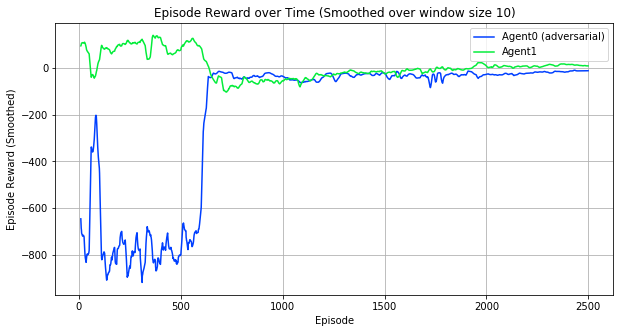

In [12]:
plot_smooth(agent0_reward_list, agent1_reward_list, smoothing_window = 10)

### Demo with trained agents

C:\Users\nbbor\Anaconda3\envs\tf17\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



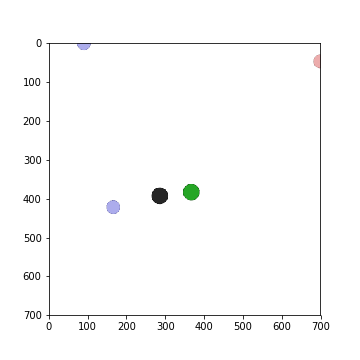
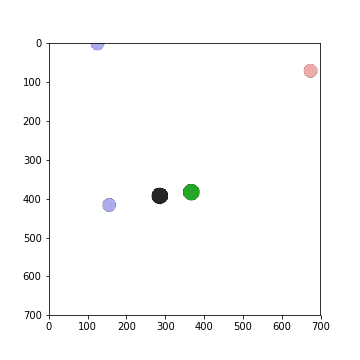
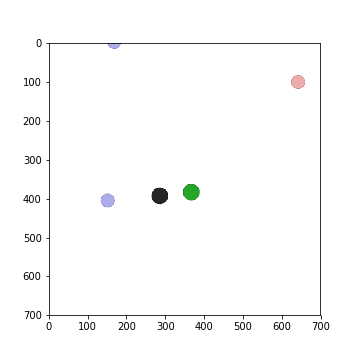
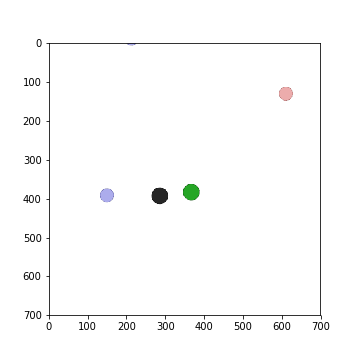
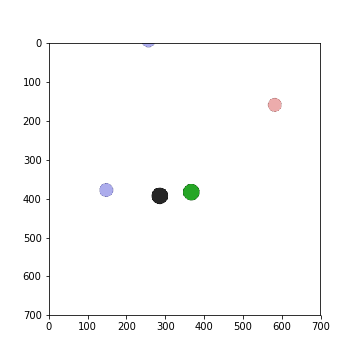
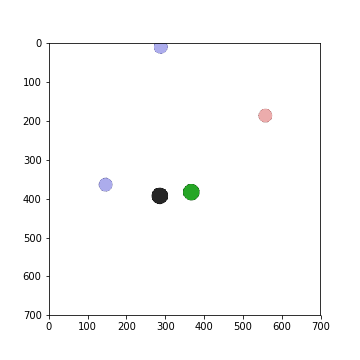
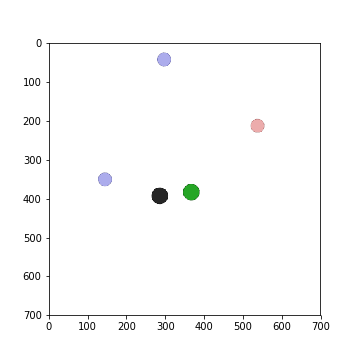
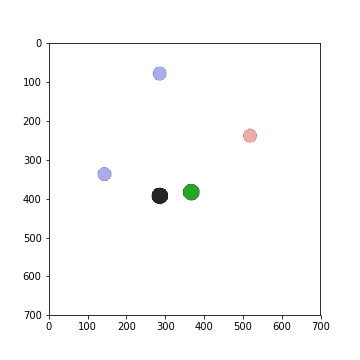
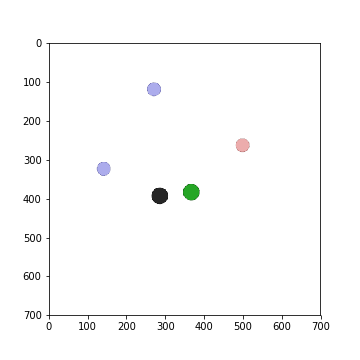
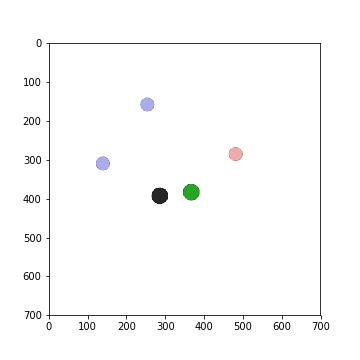
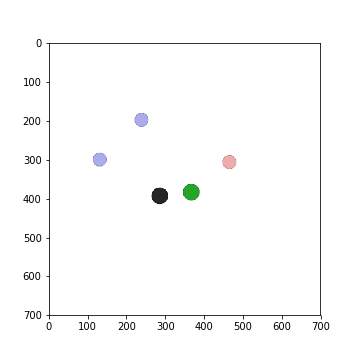
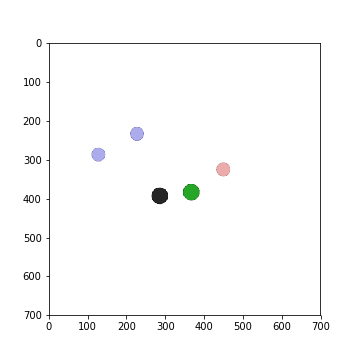
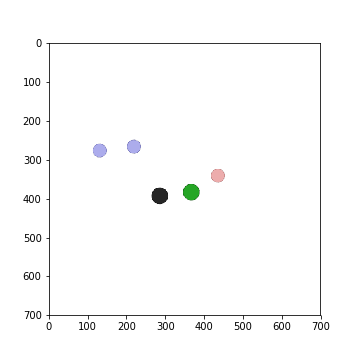
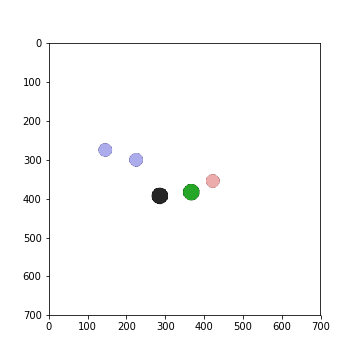
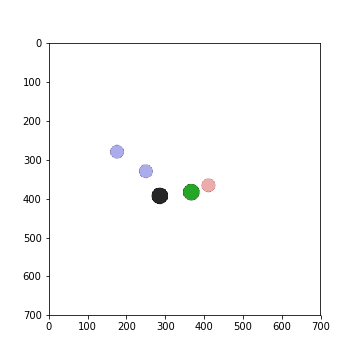
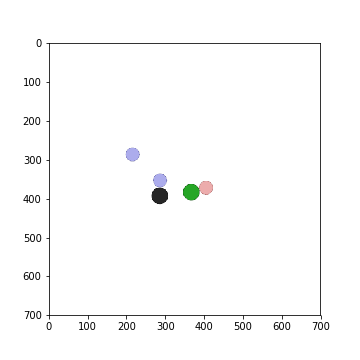
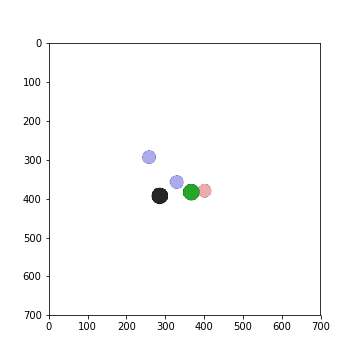
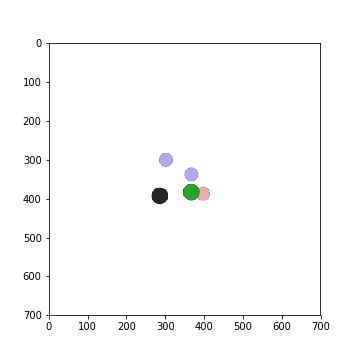
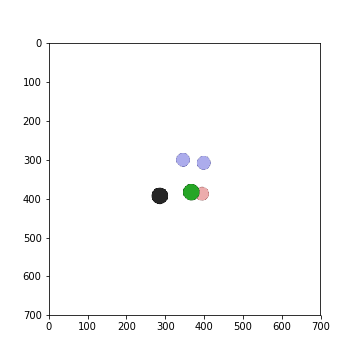
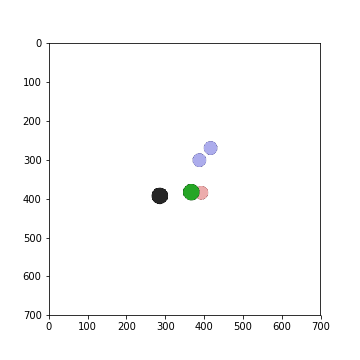
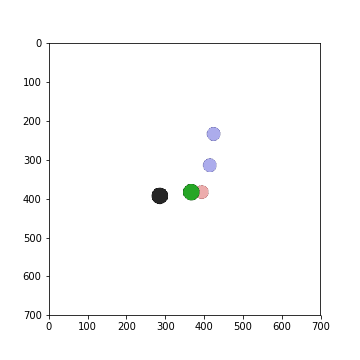
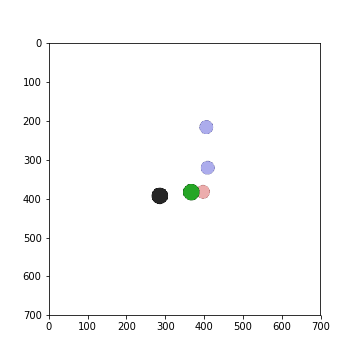
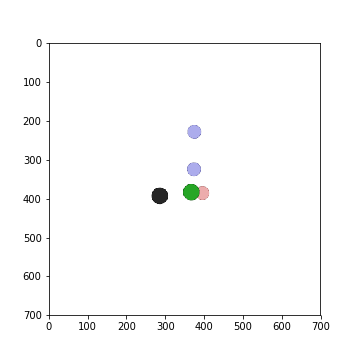
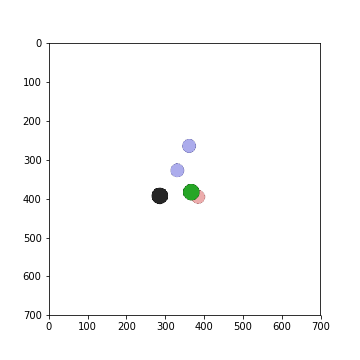
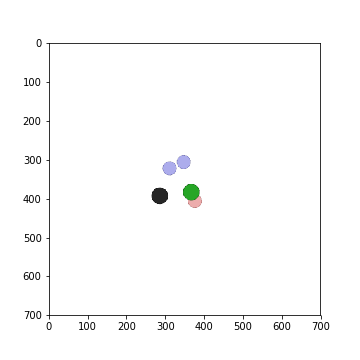
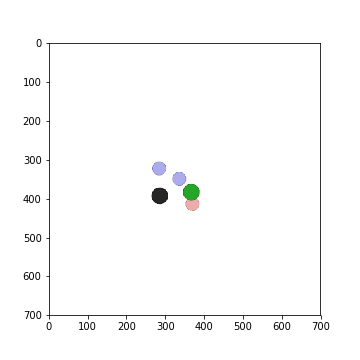
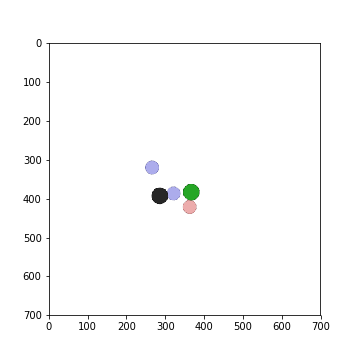
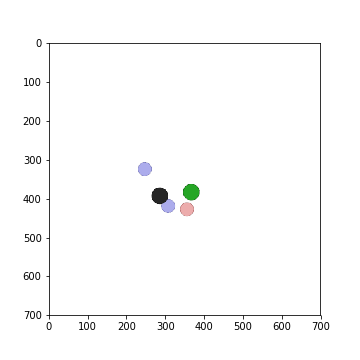
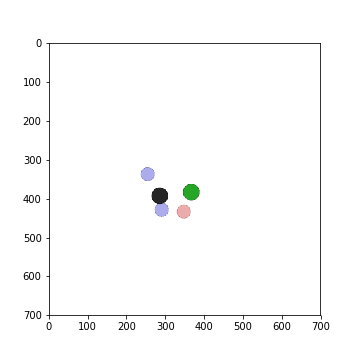
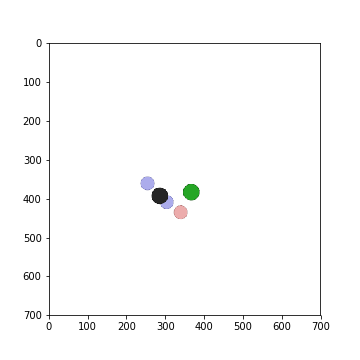
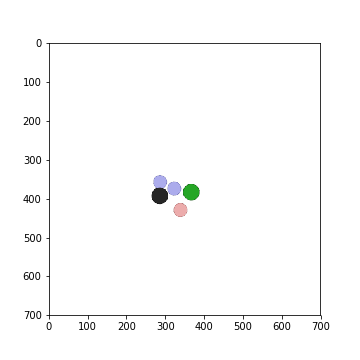
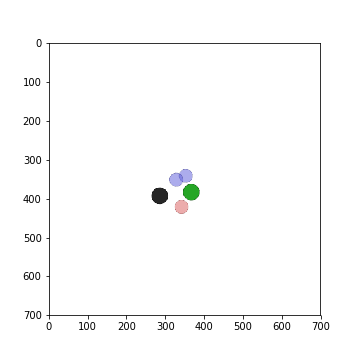
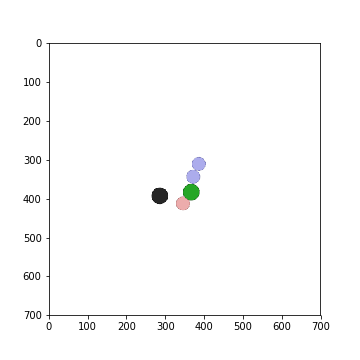
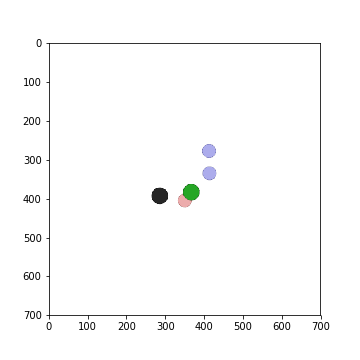
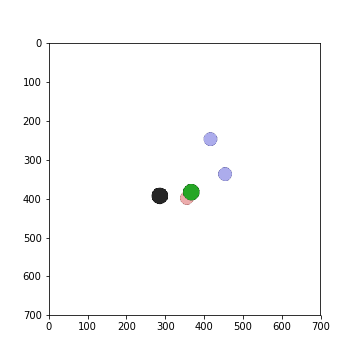
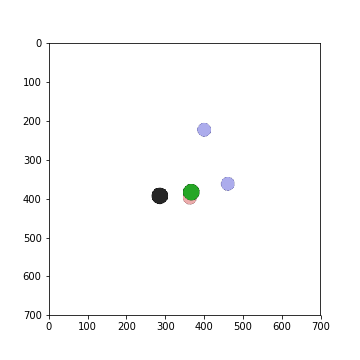
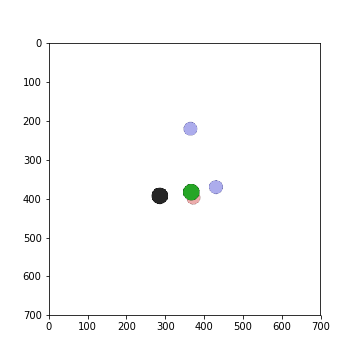
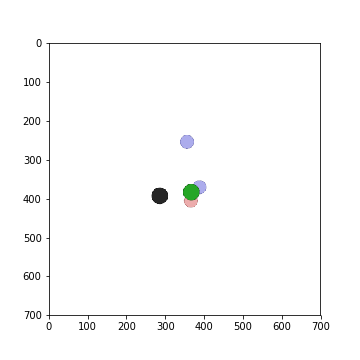
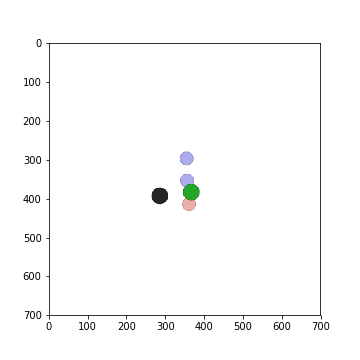
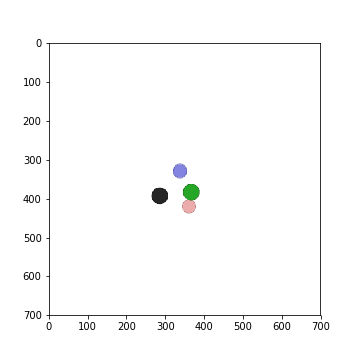
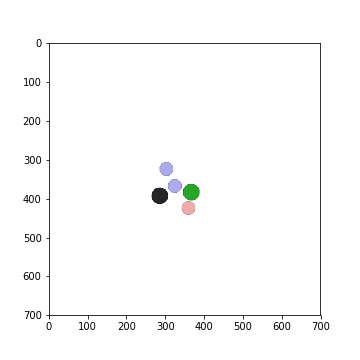
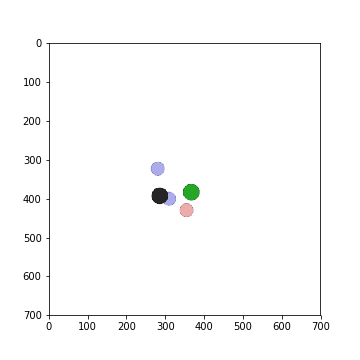
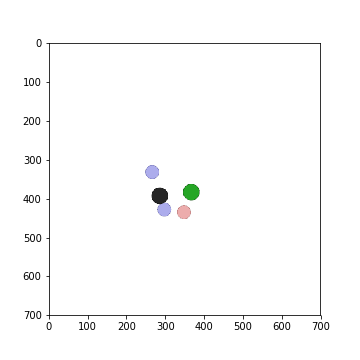
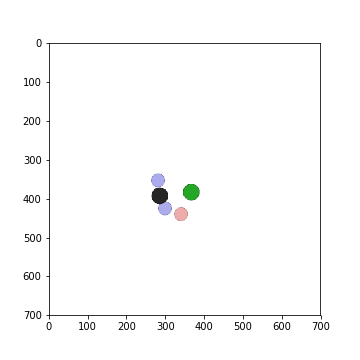
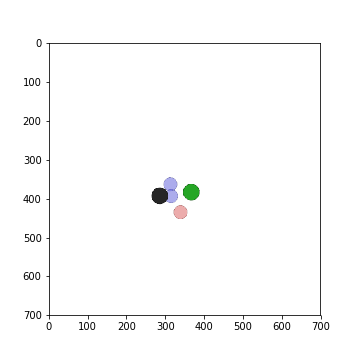
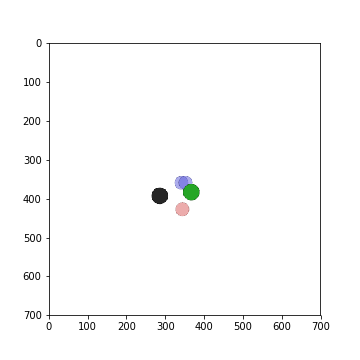
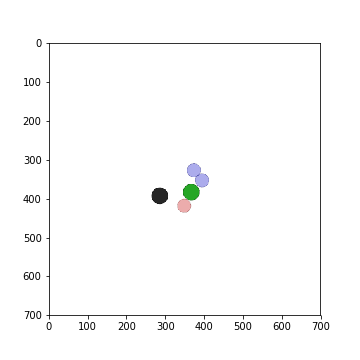
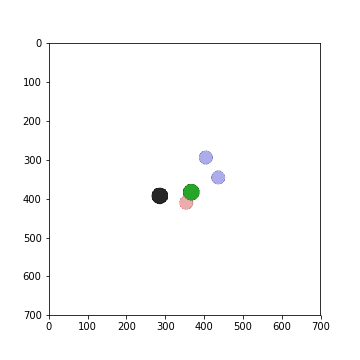
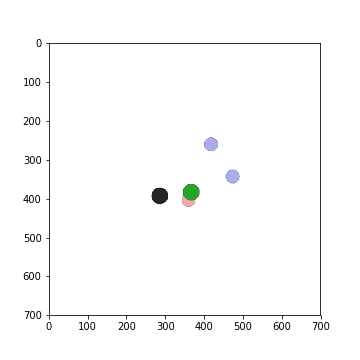
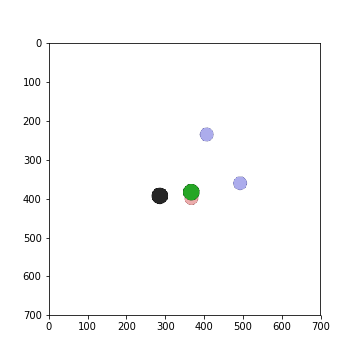
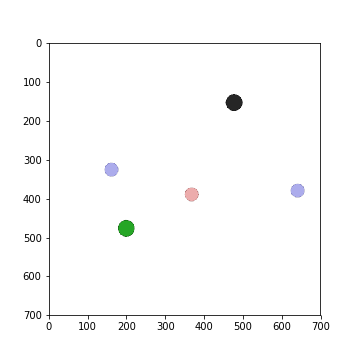
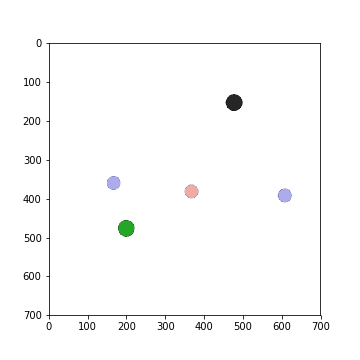
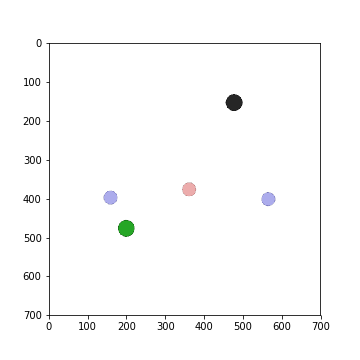
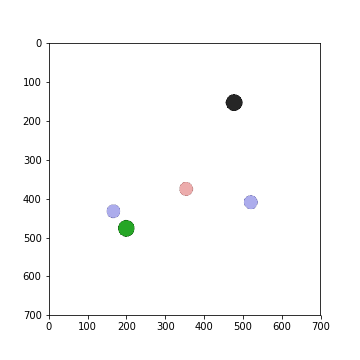
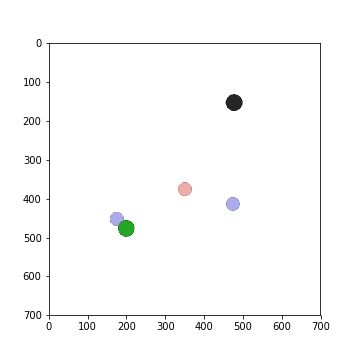
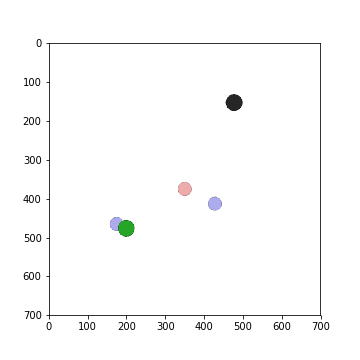
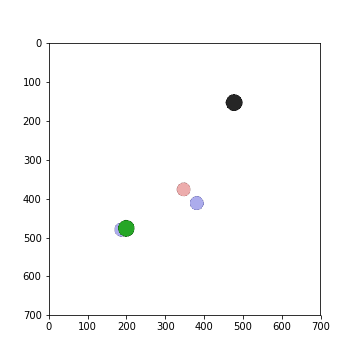
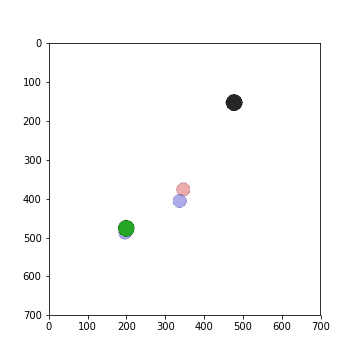
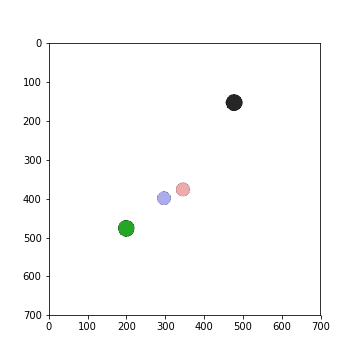
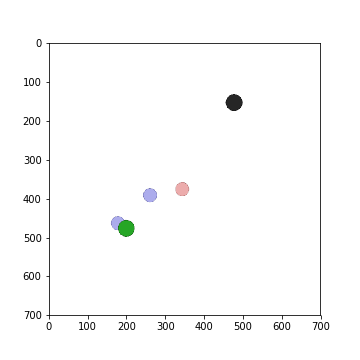
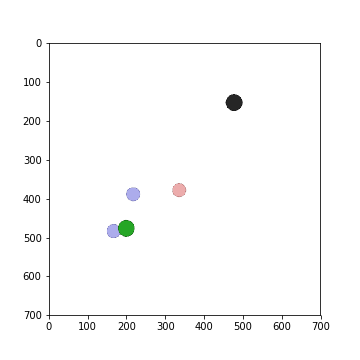
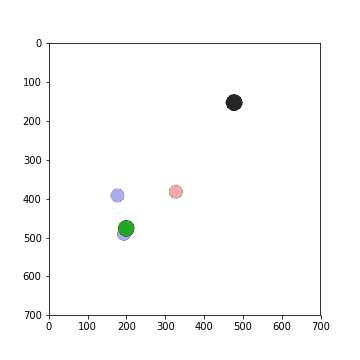
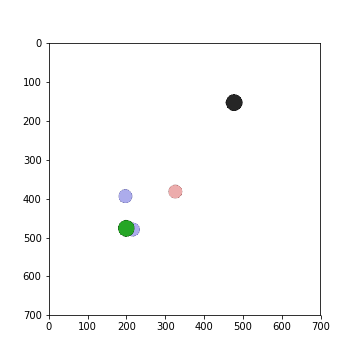
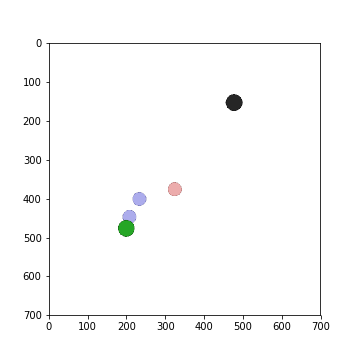
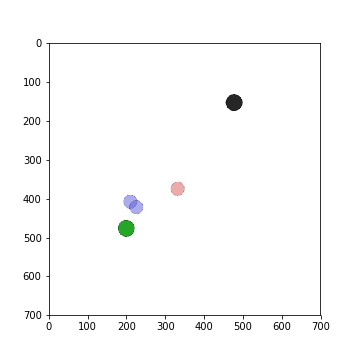
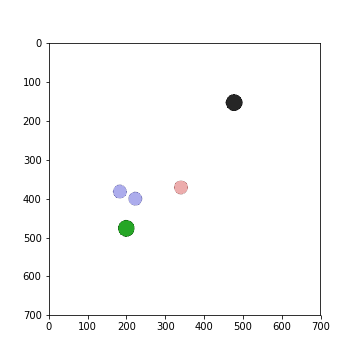
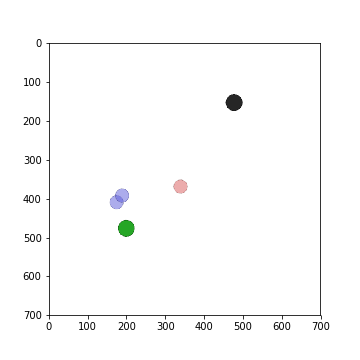
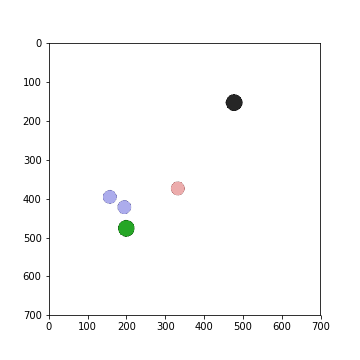
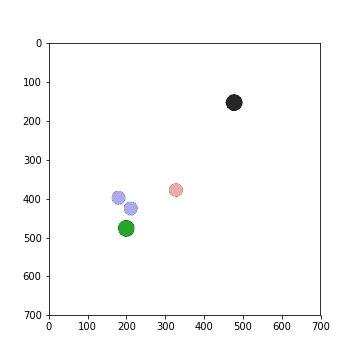
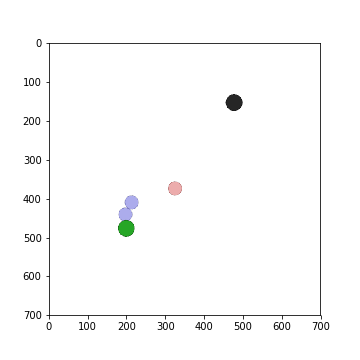
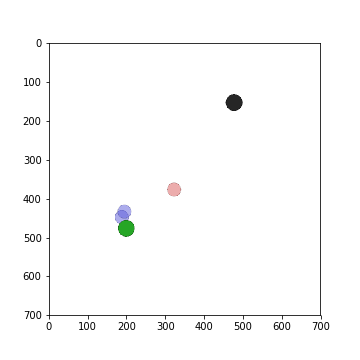
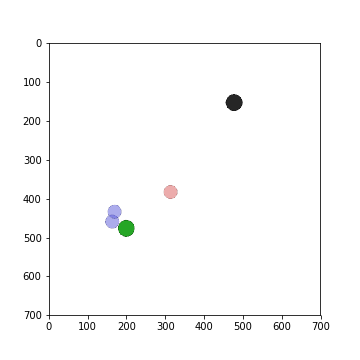
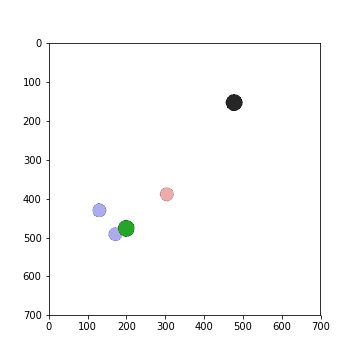
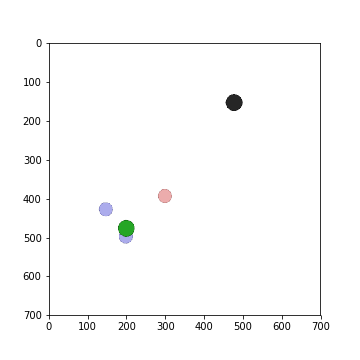
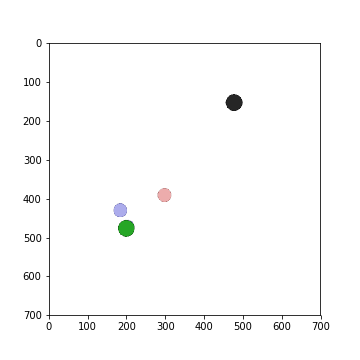
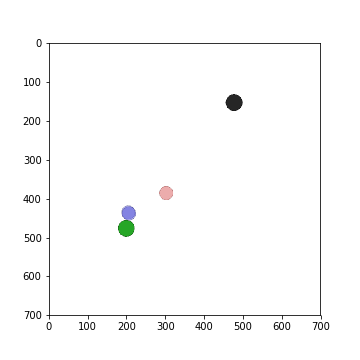
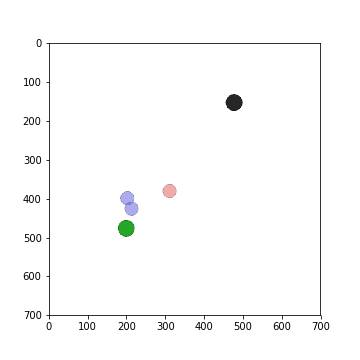
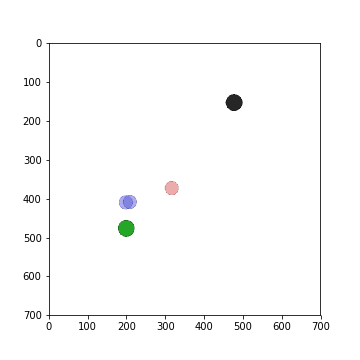
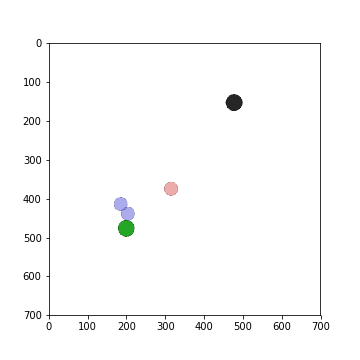
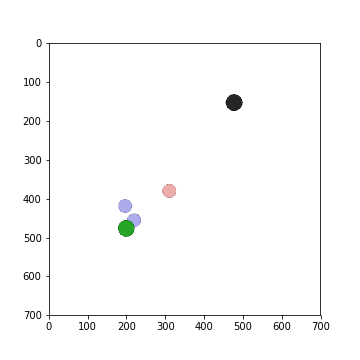
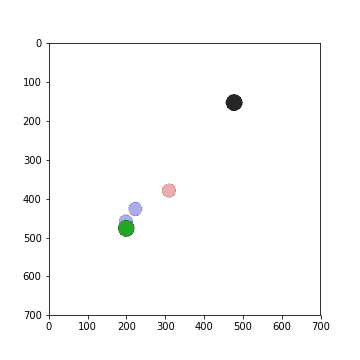
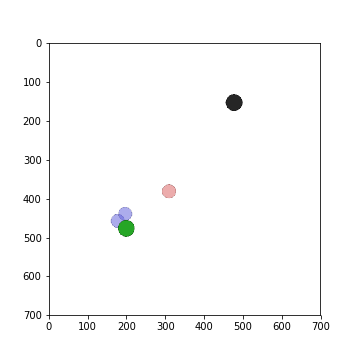
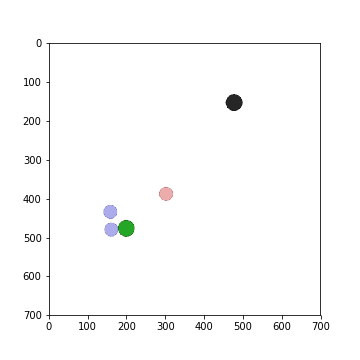
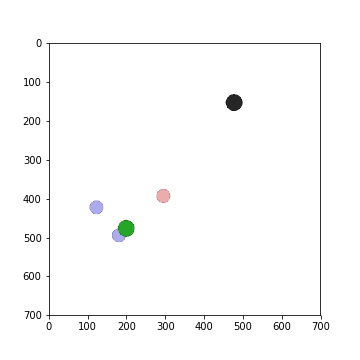
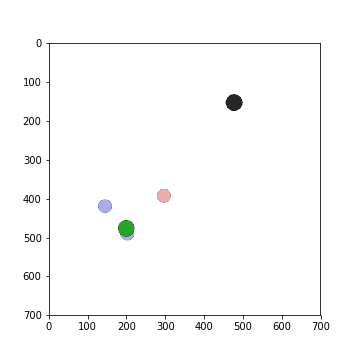
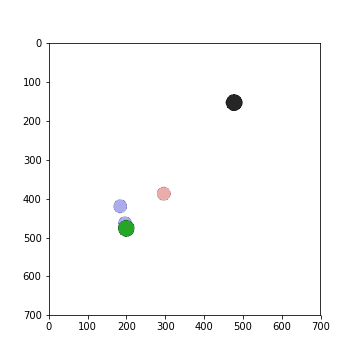
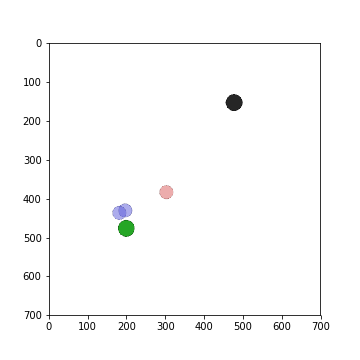
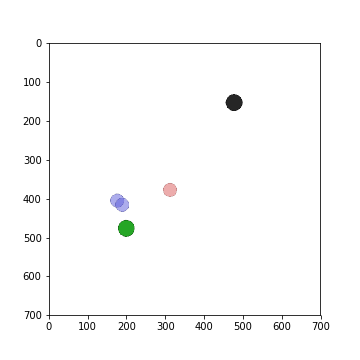
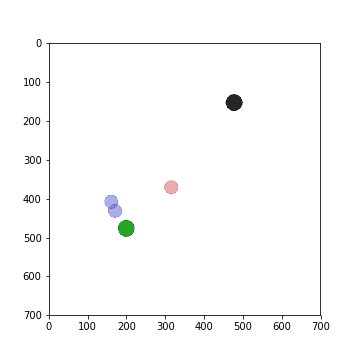
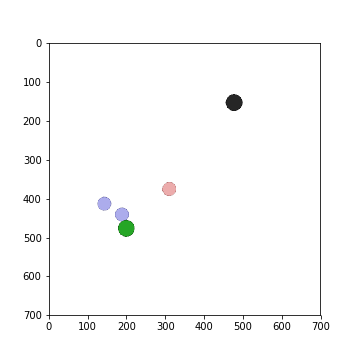
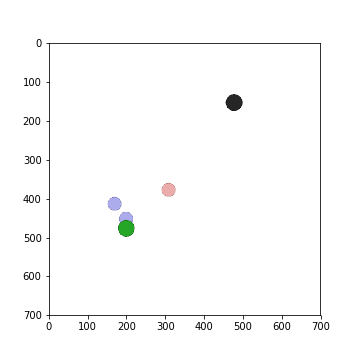
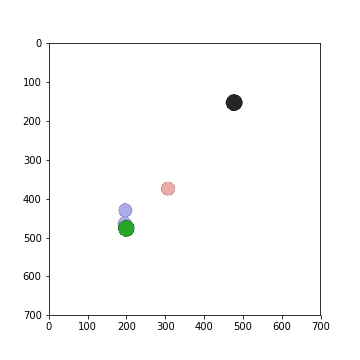
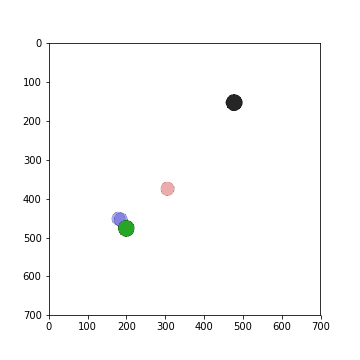
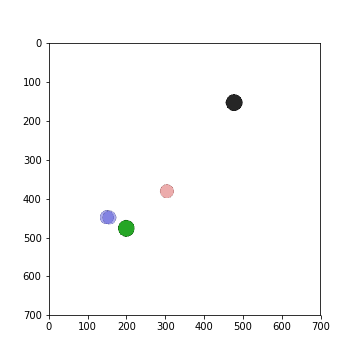
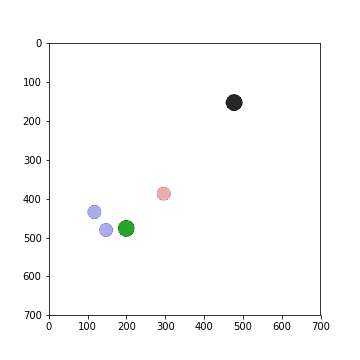
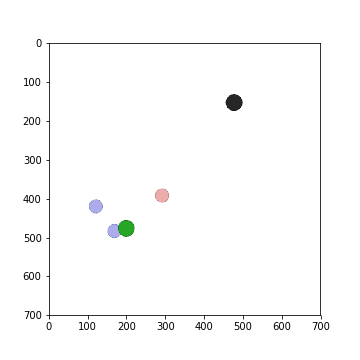
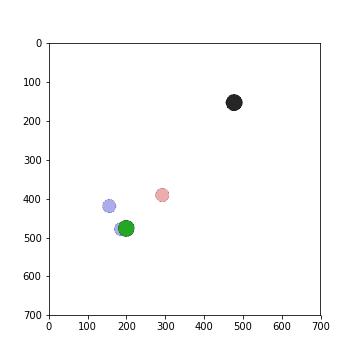
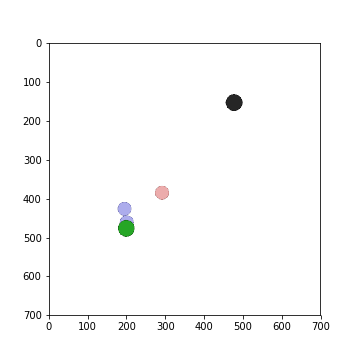
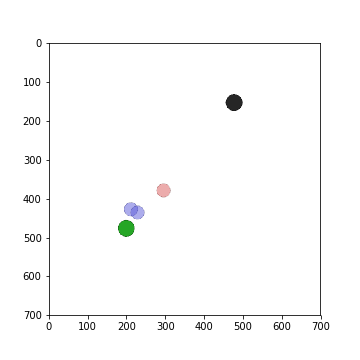
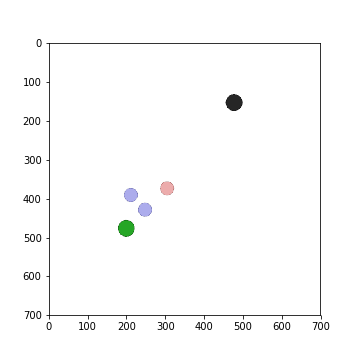
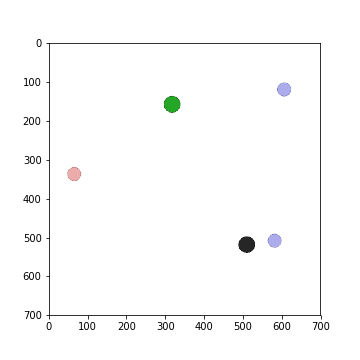
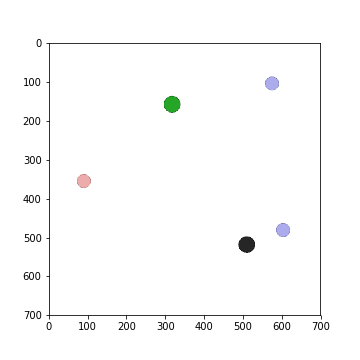
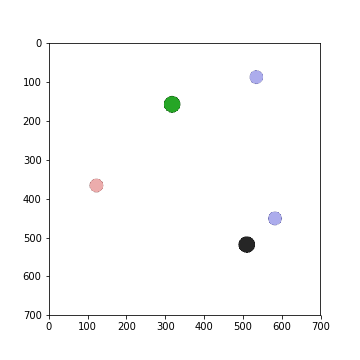
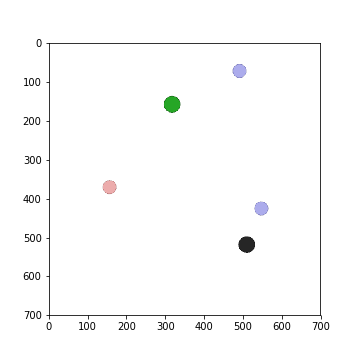
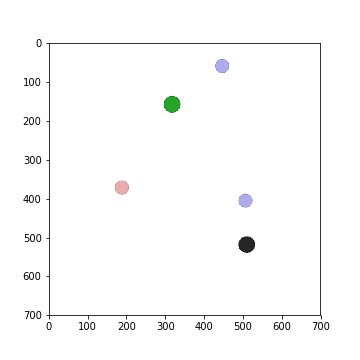
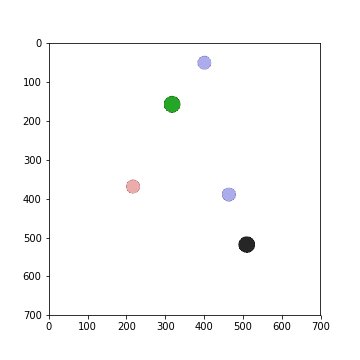
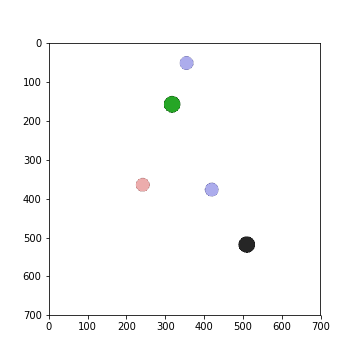
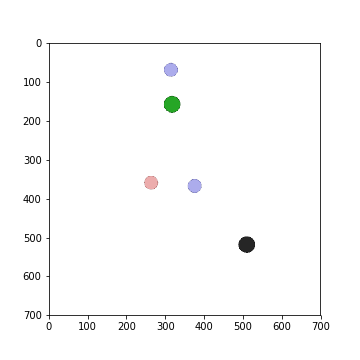
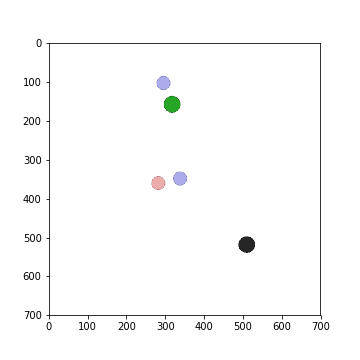
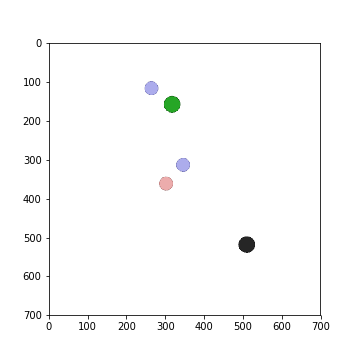
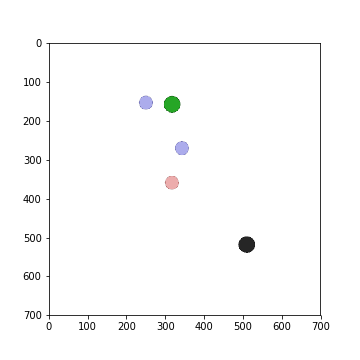
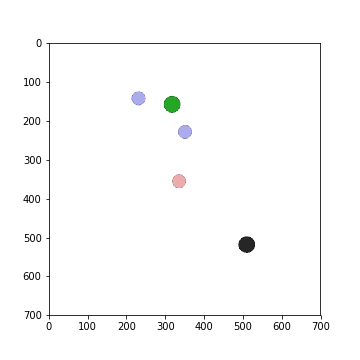
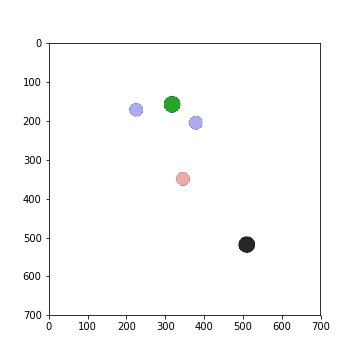
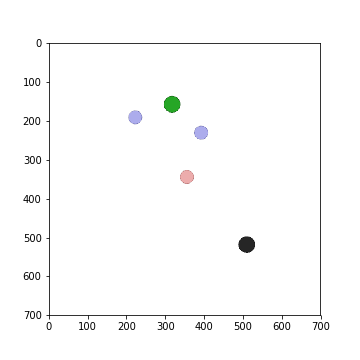
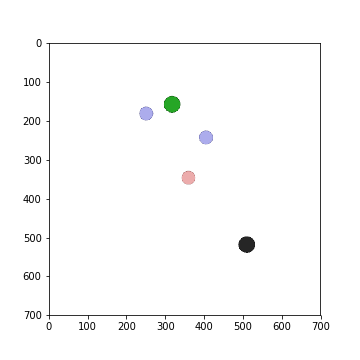
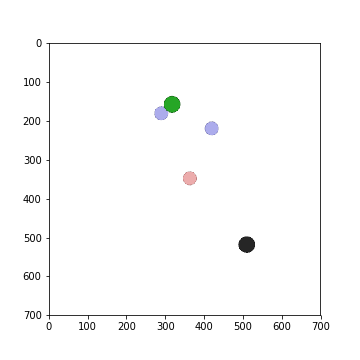
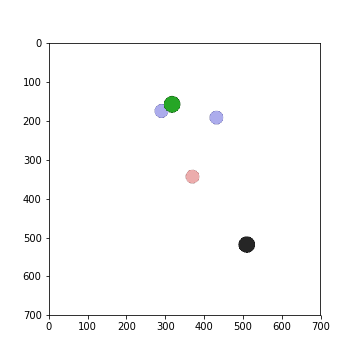
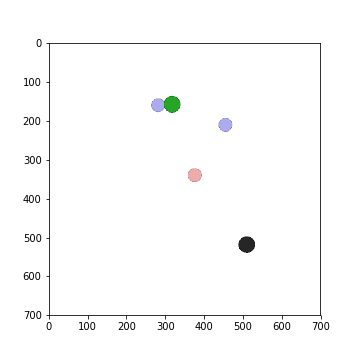
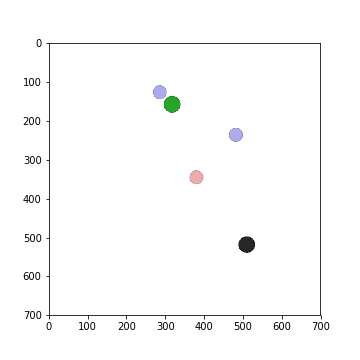
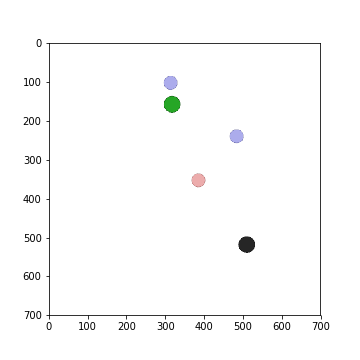
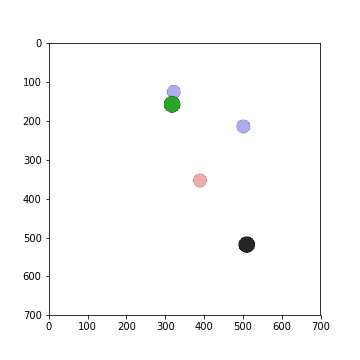
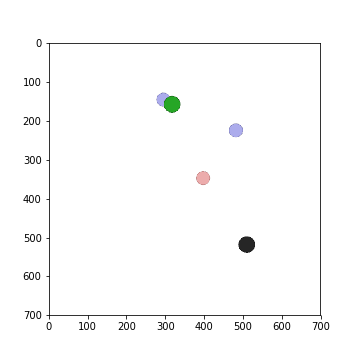
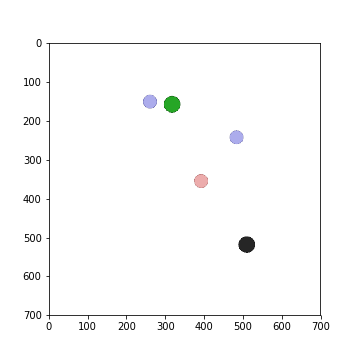
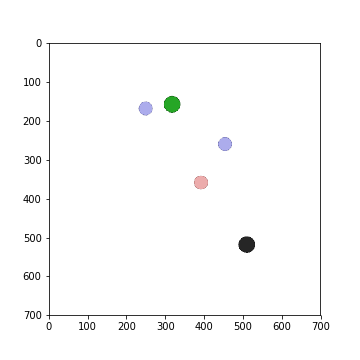
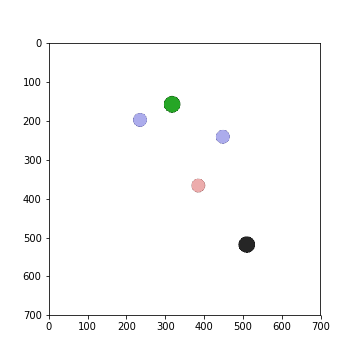
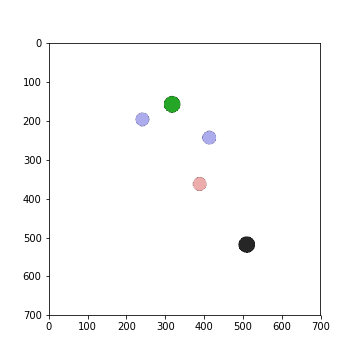
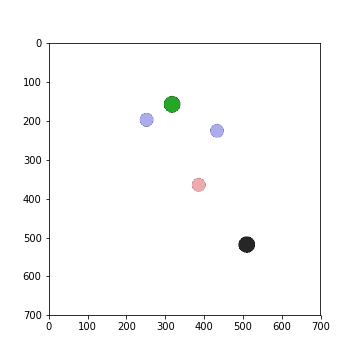
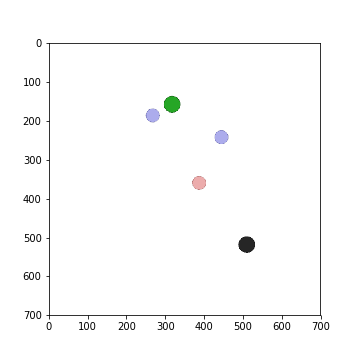
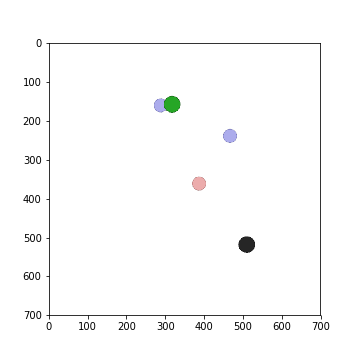
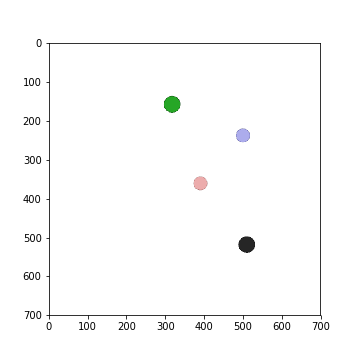
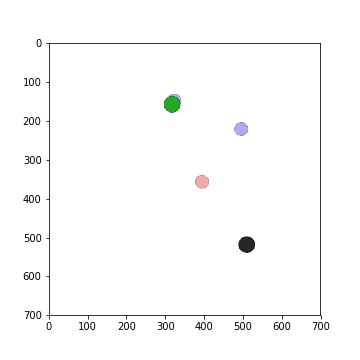
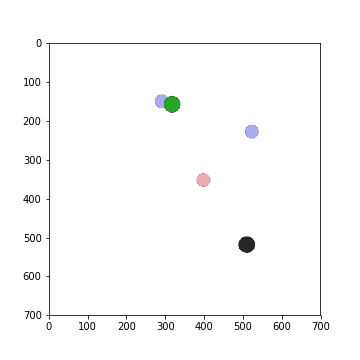
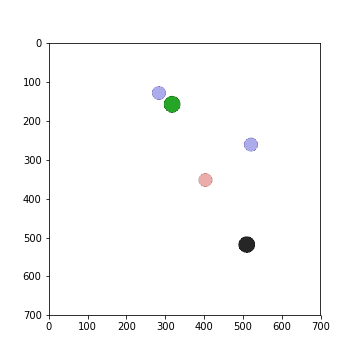
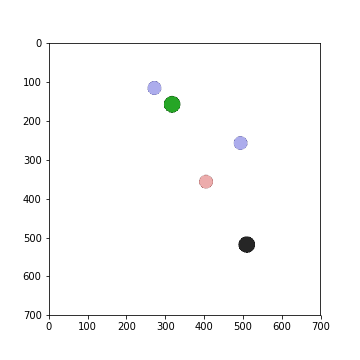
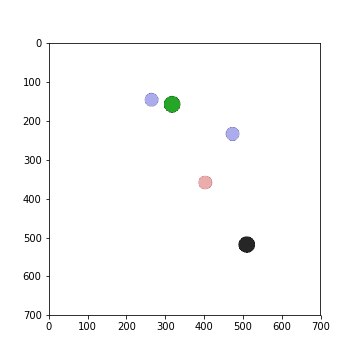
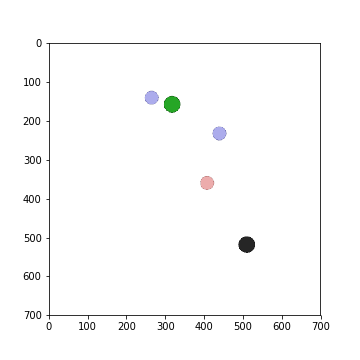
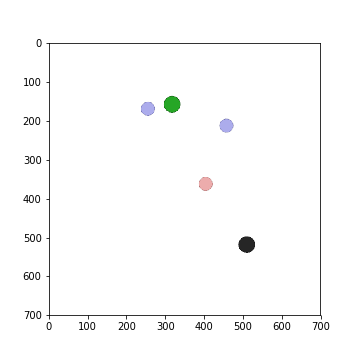
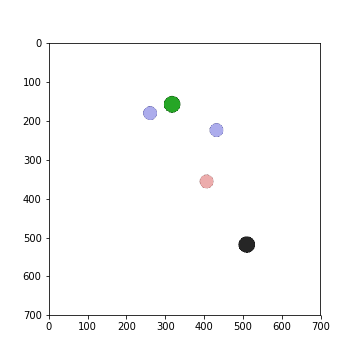
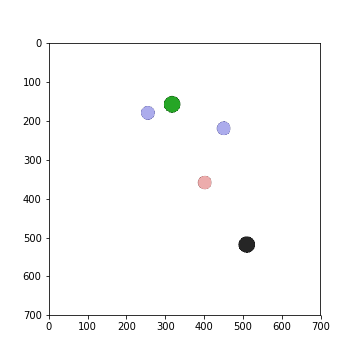
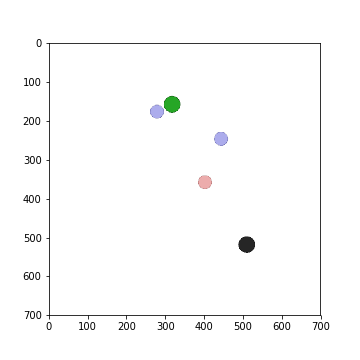
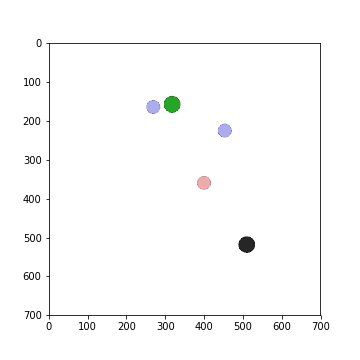
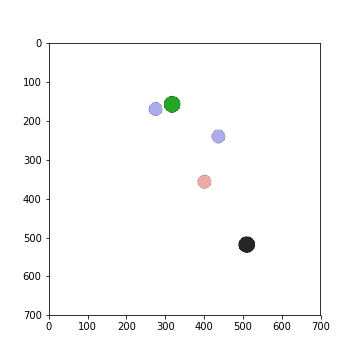
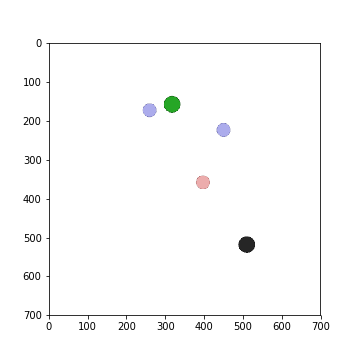
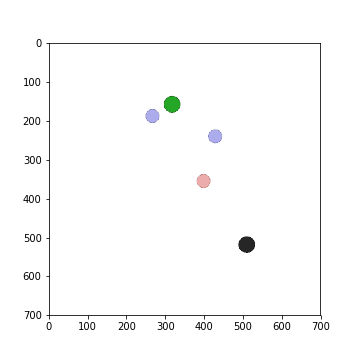
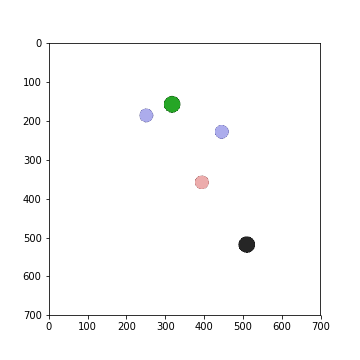
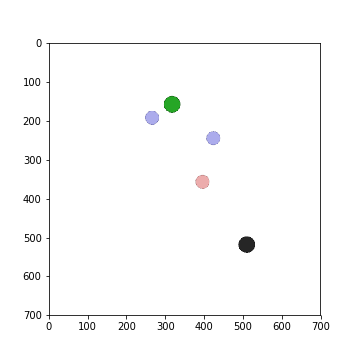
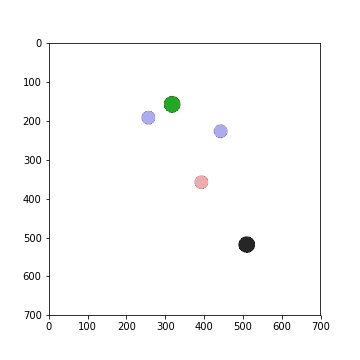
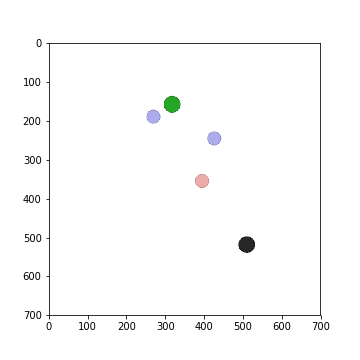
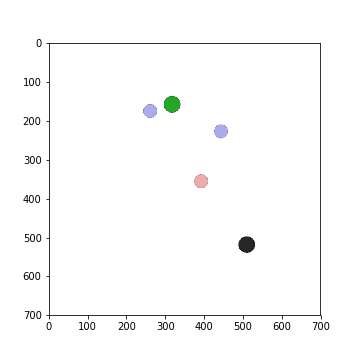
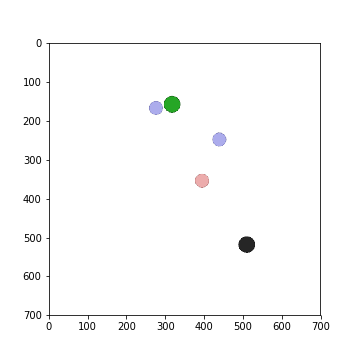
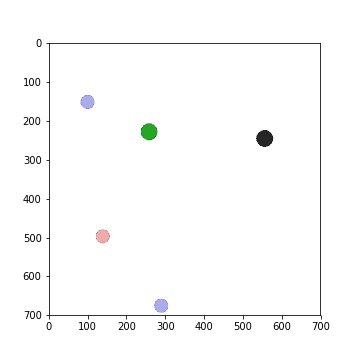
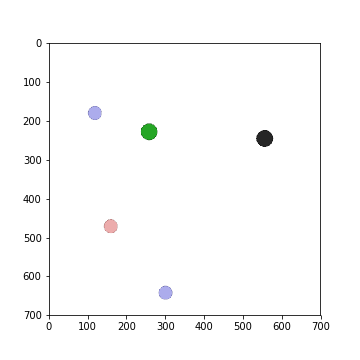
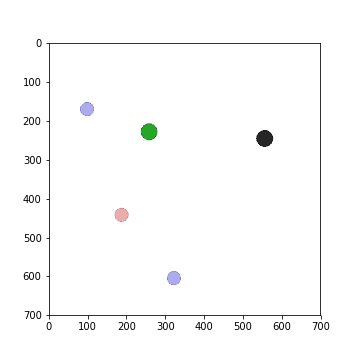
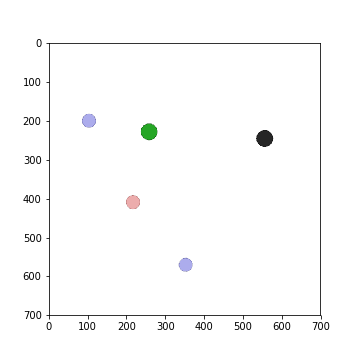
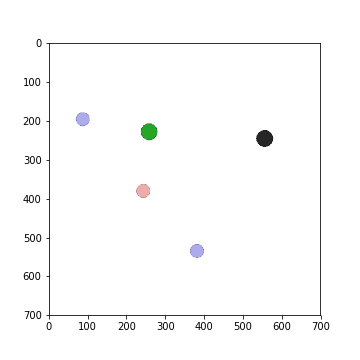
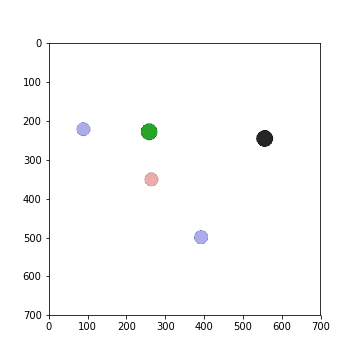
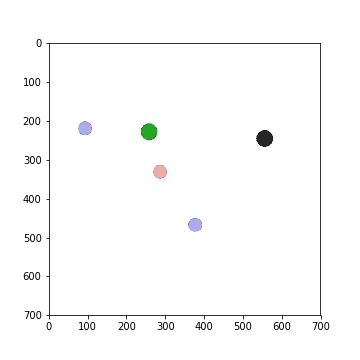
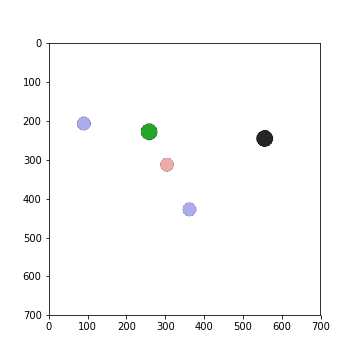
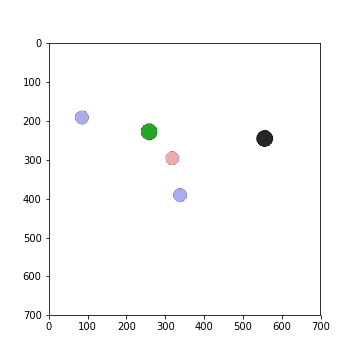
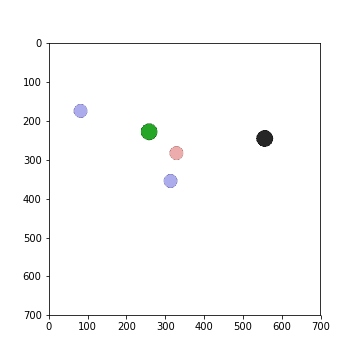
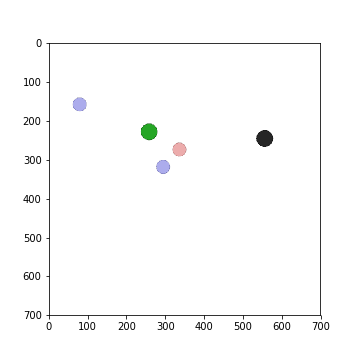
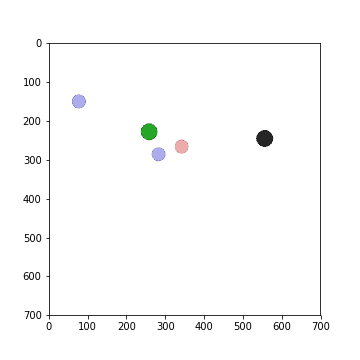
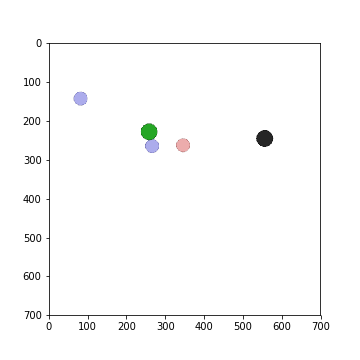
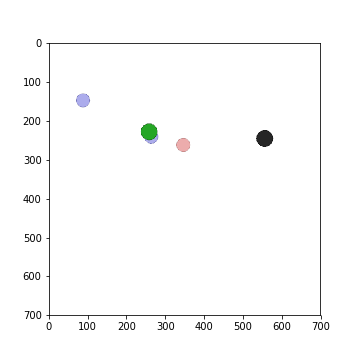
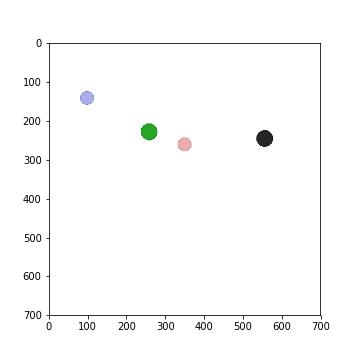
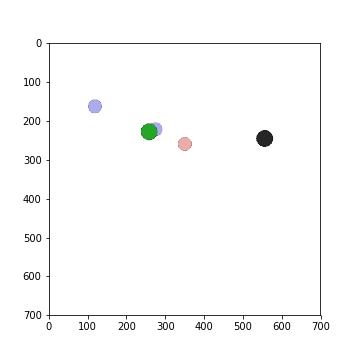
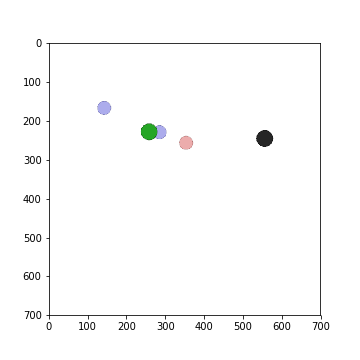
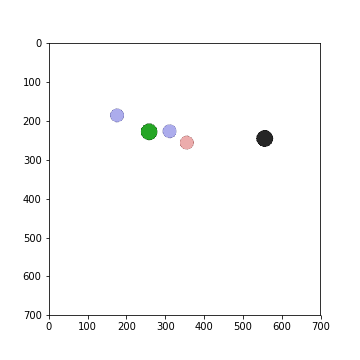
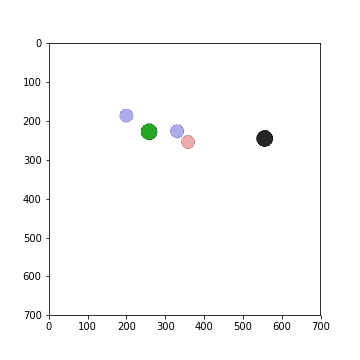
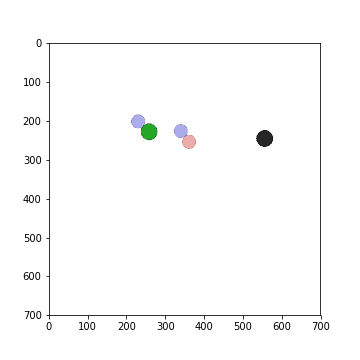
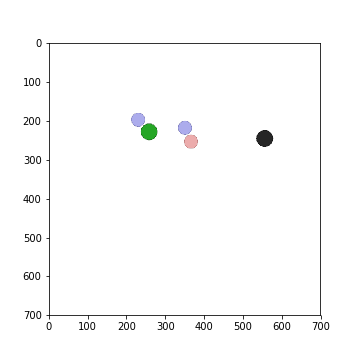
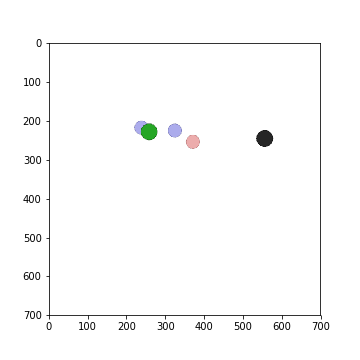
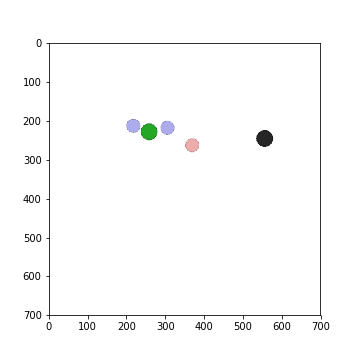
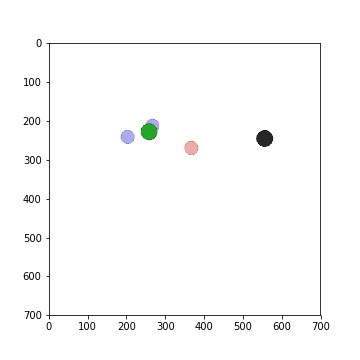
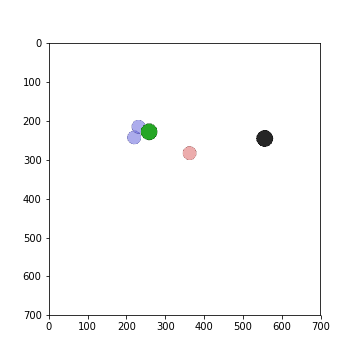
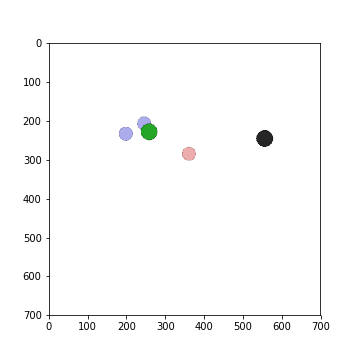
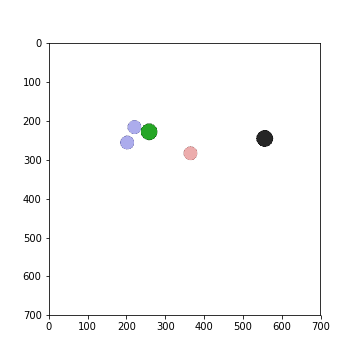
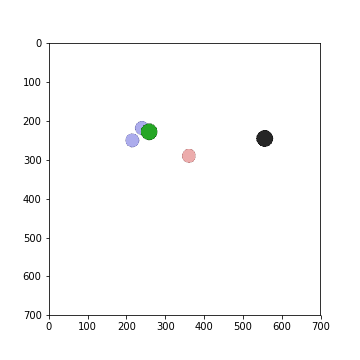
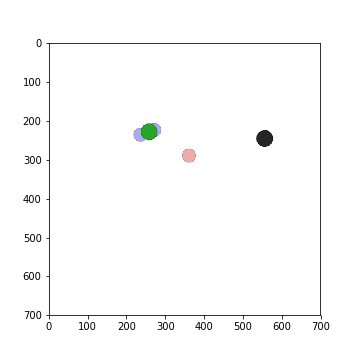
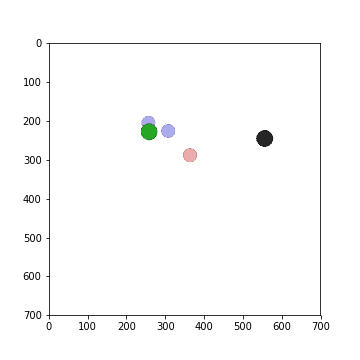
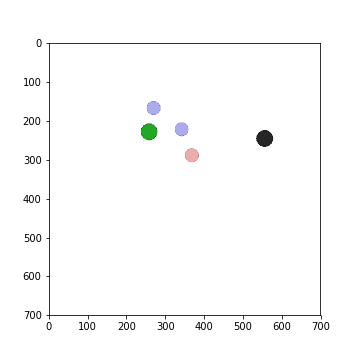
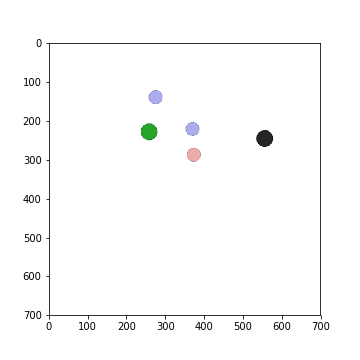
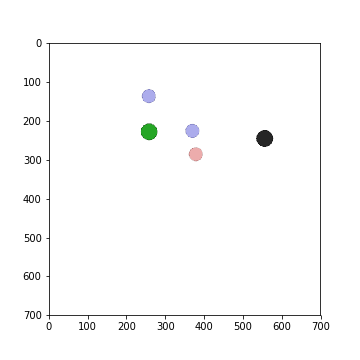
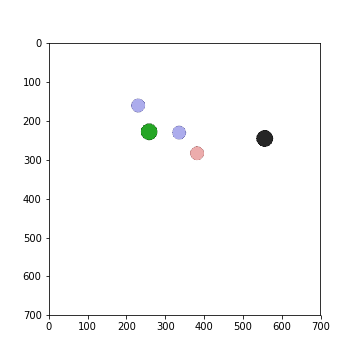
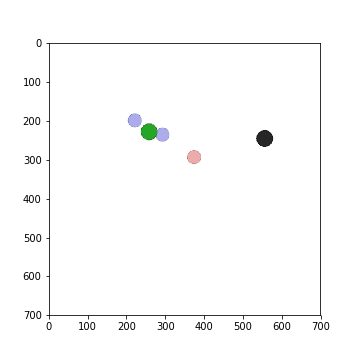
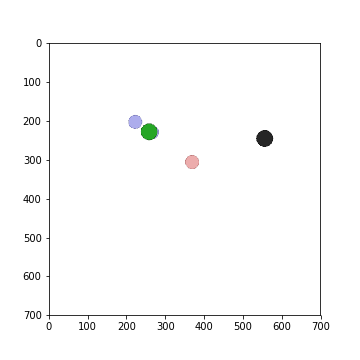
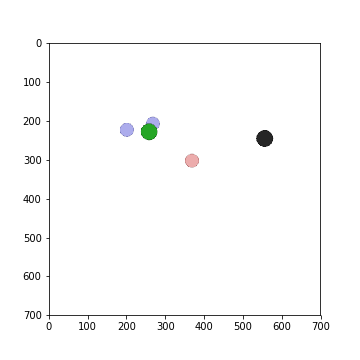
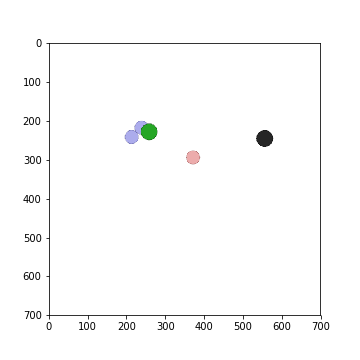
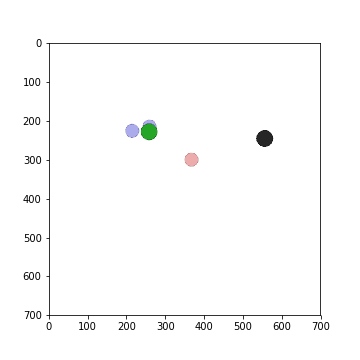
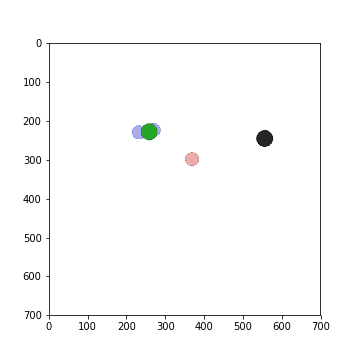
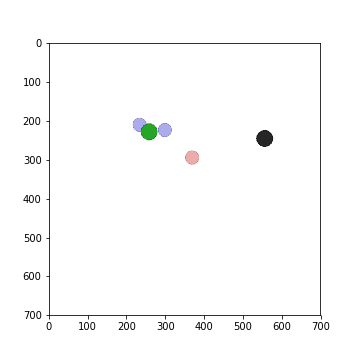
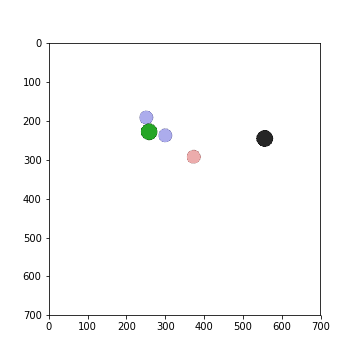
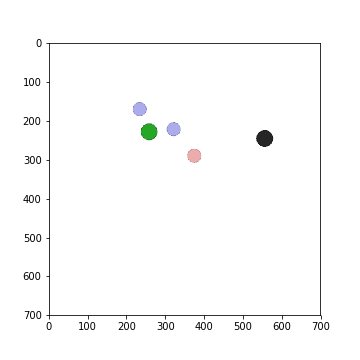
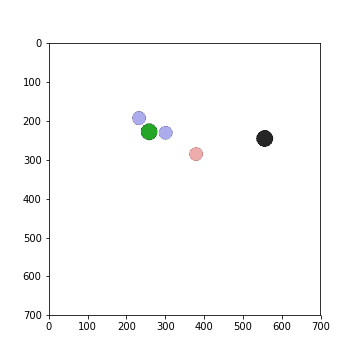
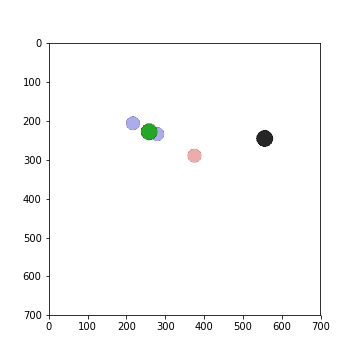
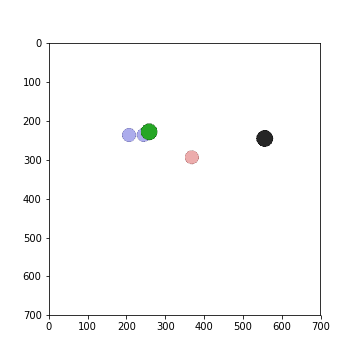
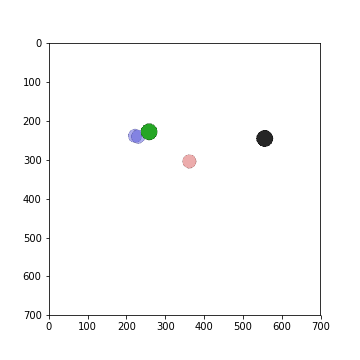
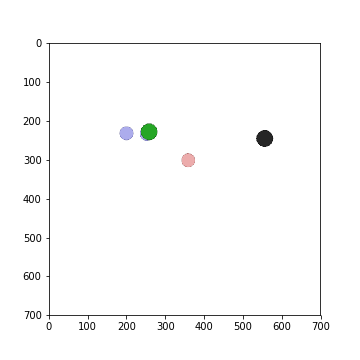
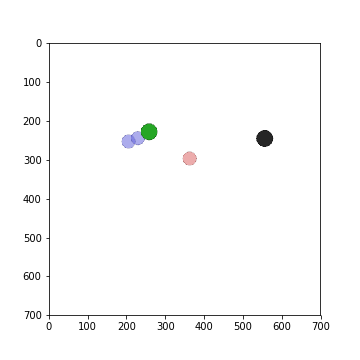
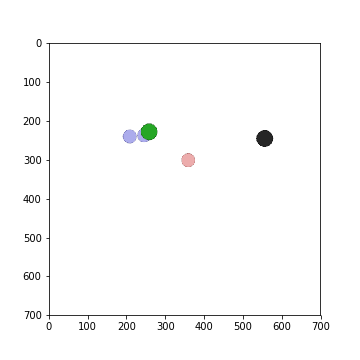
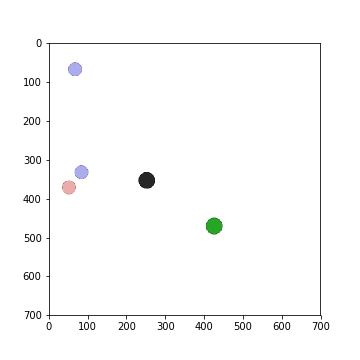
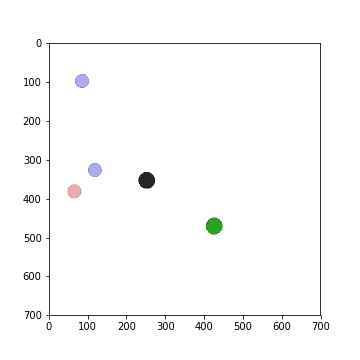
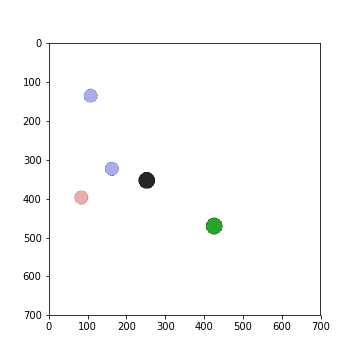
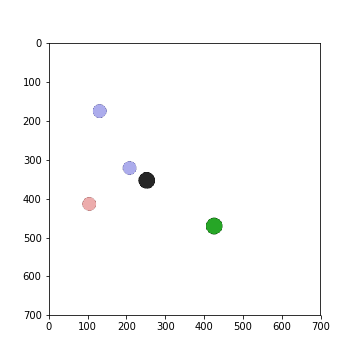
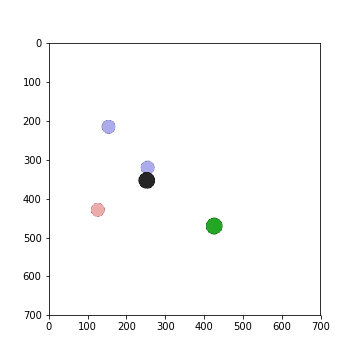
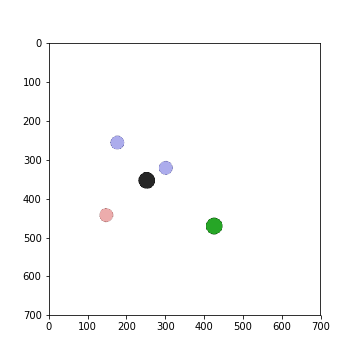
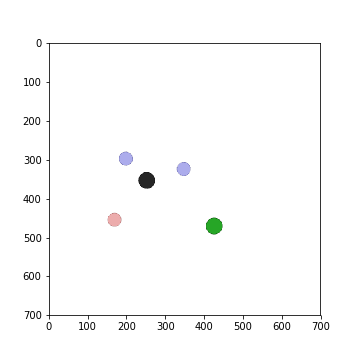
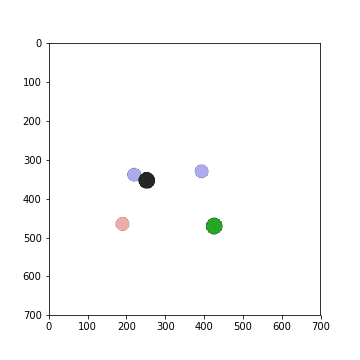
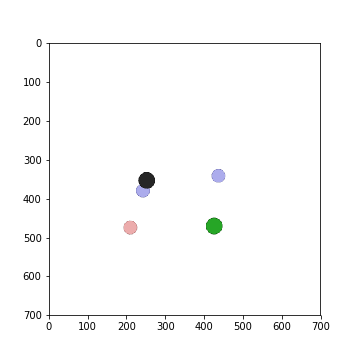
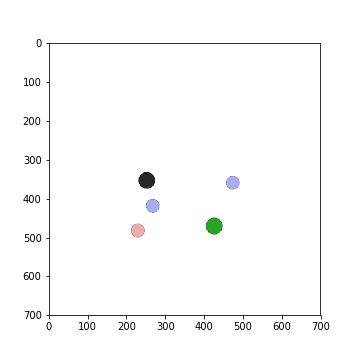
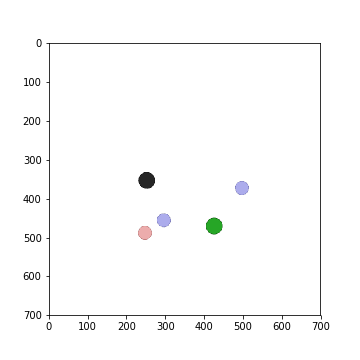
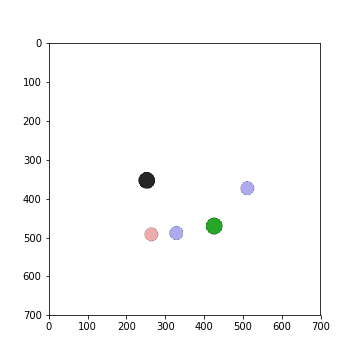
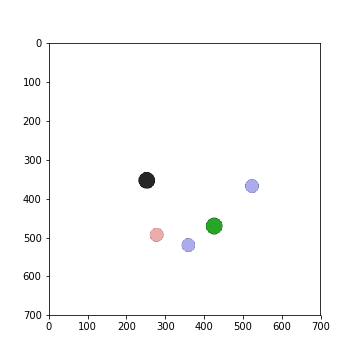
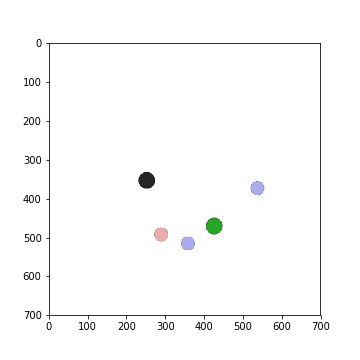
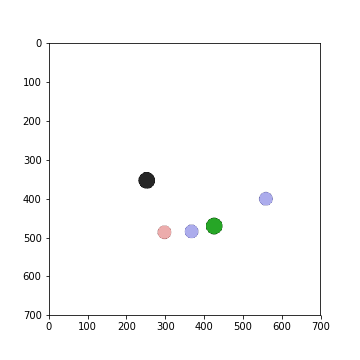
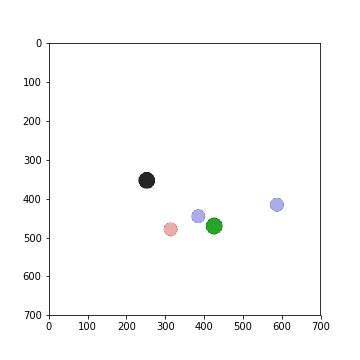
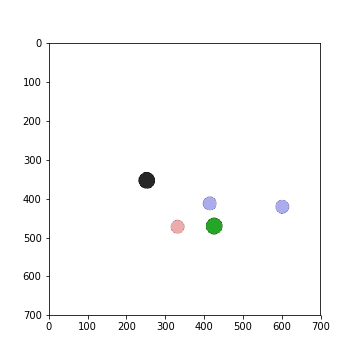
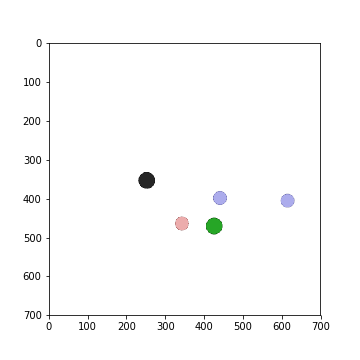
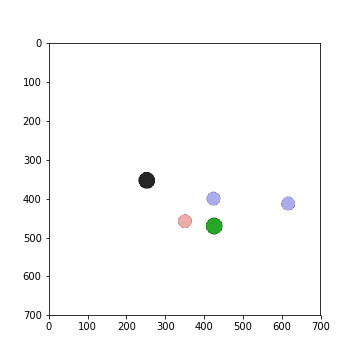
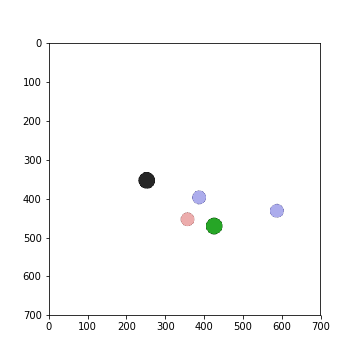
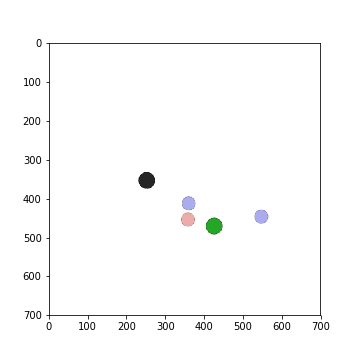
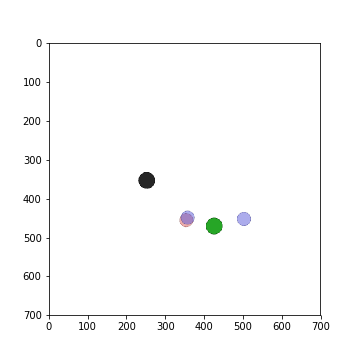
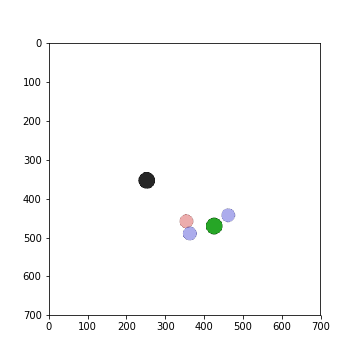
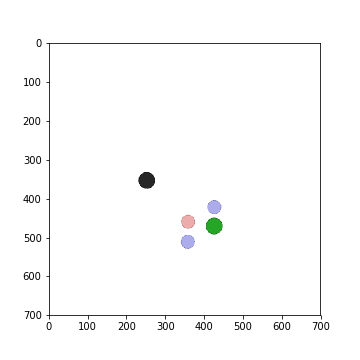
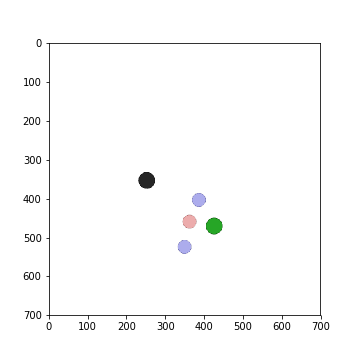
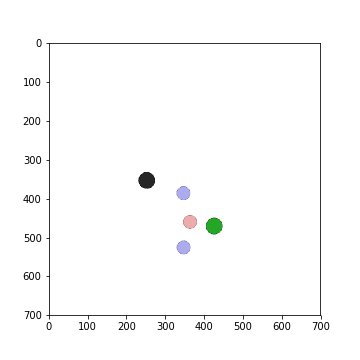
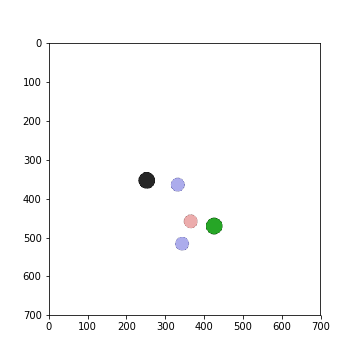
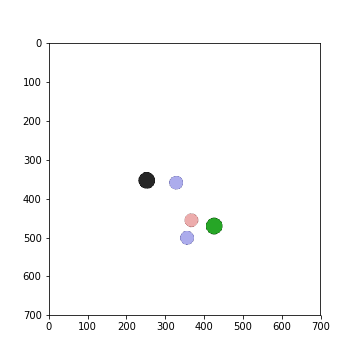
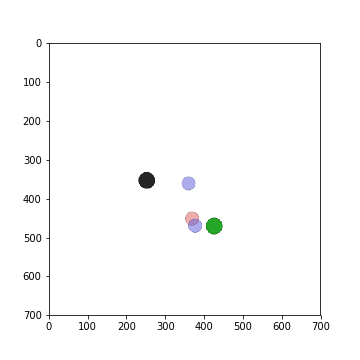
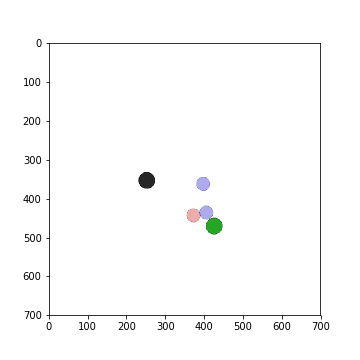
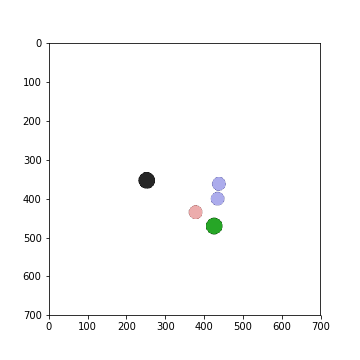
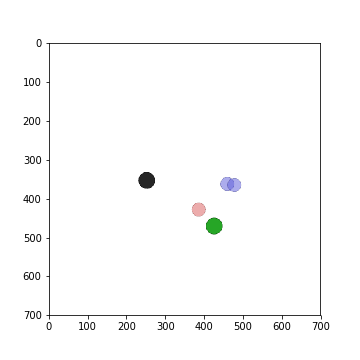
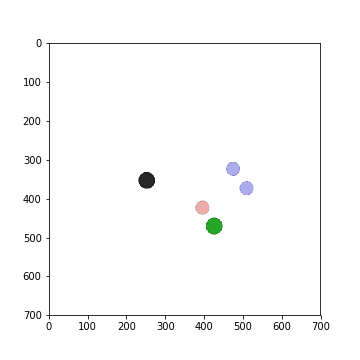
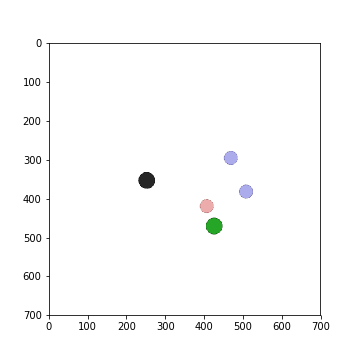
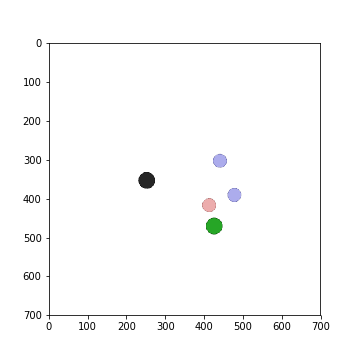
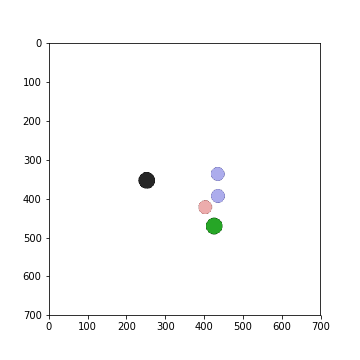
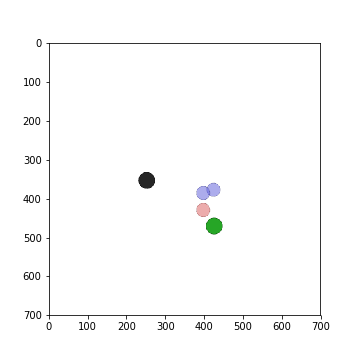
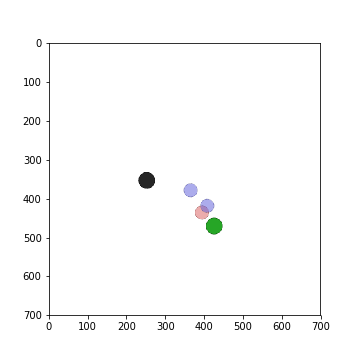
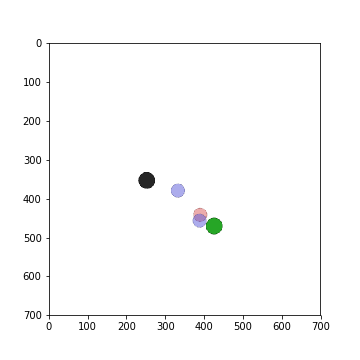
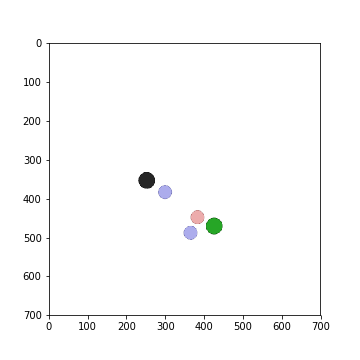
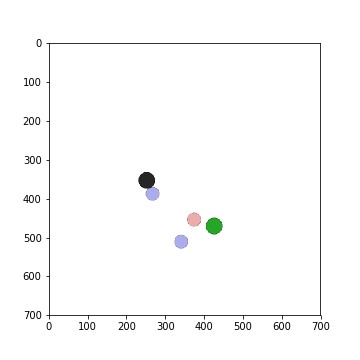
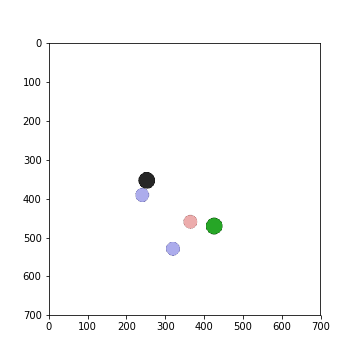
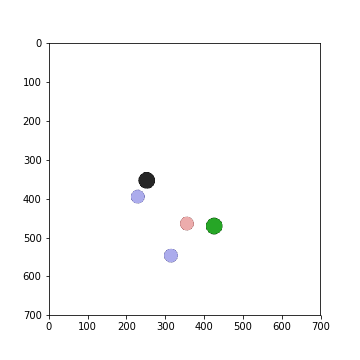
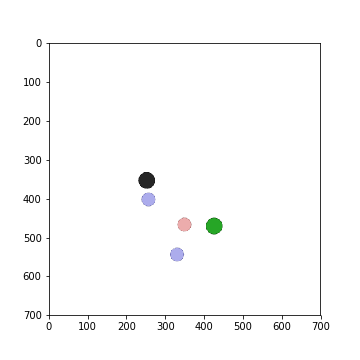
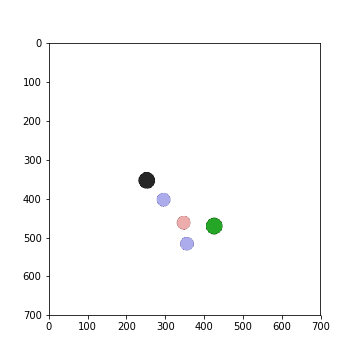
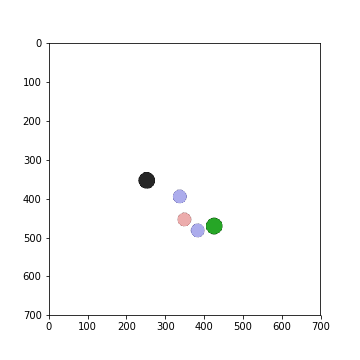
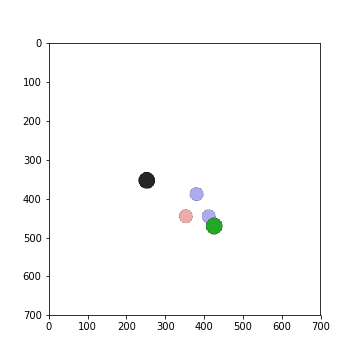
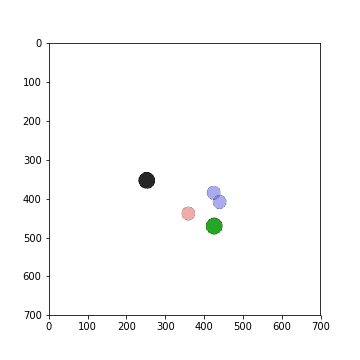
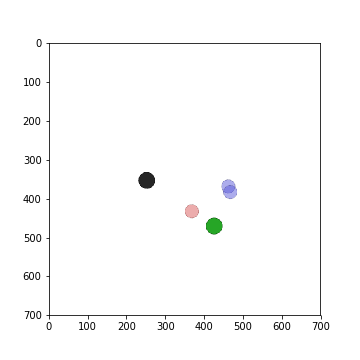
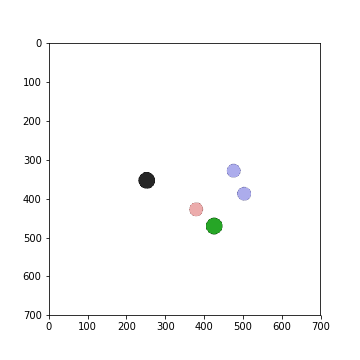

In [14]:
# Now demo with trained agents on 5 episodes (much interesting!)
play_demo('physical_deception.gif',"simple_adversary", 5, False)